In [1]:
import pandas as pd
import pickle as pkl
import numpy as np 
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_curve, f1_score

plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 10
plt.rcParams["figure.dpi"] = 600
sns.set()

# Import data

In [2]:
fire_data = pd.DataFrame(pd.read_pickle('data/gridmet5.pkl')).dropna()
fire_data.columns = pd.read_pickle('data/gridmetCols.pkl')

# convert data type
fire_data = fire_data.apply(pd.to_numeric, errors='ignore')
fire_data.day = pd.to_datetime(fire_data.day)

# # remove outliers: might not make sense to do
# fire_num = fire_data.select_dtypes(include=np.number)
# fire_num = fire_num[(np.abs(stats.zscore(fire_num)) < 3).all(axis=1)]
# fire_not = fire_data.select_dtypes(exclude=np.number)
# fire_data = (fire_num.merge(fire_not, left_index=True, right_index=True)
#             .reset_index(drop=True))

fire_data.info()
display(fire_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122342 entries, 0 to 122341
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   day                122342 non-null  datetime64[ns]
 1   season             122342 non-null  object        
 2   burning_index_g    122342 non-null  float64       
 3   relative_humidity  122342 non-null  float64       
 4   air_temperature    122342 non-null  float64       
 5   wind_speed         122342 non-null  float64       
 6   fire               122342 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 6.5+ MB


day  season  burning_index_g  relative_humidity  air_temperature  \
0 2017-01-01  winter              0.0          55.100002       273.799988   
1 2017-01-01  winter              0.0          43.700001       277.000000   
2 2017-01-01  winter              0.0          47.799999       276.000000   
3 2017-01-01  winter              0.0          63.900002       272.100006   
4 2017-01-01  winter              0.0          53.299999       273.299988   

   wind_speed  fire  
0         4.6     0  
1         4.8     0  
2         5.1     0  
3         5.6     0  
4         6.0     0

## Get Sample (n=40000)

In [3]:
fire_samp = fire_data.sample(n=40000, random_state=88)
fire_samp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 96420 to 25954
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   day                40000 non-null  datetime64[ns]
 1   season             40000 non-null  object        
 2   burning_index_g    40000 non-null  float64       
 3   relative_humidity  40000 non-null  float64       
 4   air_temperature    40000 non-null  float64       
 5   wind_speed         40000 non-null  float64       
 6   fire               40000 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 2.4+ MB


## Convert Season Column to Dummy Variable

In [4]:
fire_samp = (fire_samp.drop(['season'], axis=1)
             .merge(pd.get_dummies(fire_samp.season), 
                    left_index=True, right_index=True))
fire_samp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 96420 to 25954
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   day                40000 non-null  datetime64[ns]
 1   burning_index_g    40000 non-null  float64       
 2   relative_humidity  40000 non-null  float64       
 3   air_temperature    40000 non-null  float64       
 4   wind_speed         40000 non-null  float64       
 5   fire               40000 non-null  int64         
 6   autumn             40000 non-null  uint8         
 7   spring             40000 non-null  uint8         
 8   summer             40000 non-null  uint8         
 9   winter             40000 non-null  uint8         
dtypes: datetime64[ns](1), float64(4), int64(1), uint8(4)
memory usage: 3.3 MB


## Split into train and test

In [5]:
y = fire_samp['fire']
X = fire_samp.drop(columns=['fire', 'day'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28000, 8), (12000, 8), (28000,), (12000,))

In [6]:
X_train.select_dtypes(exclude='uint8').columns

Index(['burning_index_g', 'relative_humidity', 'air_temperature',
       'wind_speed'],
      dtype='object')

# Models

In [7]:
# remove numerical columns with VIF > 5; not dummy variables
def VIF(df, columns):
    values = sm.add_constant(df[columns]).values
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    return pd.Series(vif[1:], index=columns)

VIF(X_train, X_train.select_dtypes(exclude='uint8').columns)

burning_index_g      2.899758
relative_humidity    3.309895
air_temperature      2.444346
wind_speed           1.340995
dtype: float64

In [8]:
def scores(y_test, y_pred):
    cm  = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    TPR = cm[1][1] / sum(cm[1])            # TP/(TP+FN)
    FPR = cm[0][1] / sum(cm[0])            # FP/(FP+TN)
    PRE = cm[1][1] / (cm[0][1] + cm[1][1]) # TP/(TP+FP)
    f1  = f1_score(y_test, y_pred)
    print(f'Accuracy: {acc:.4f}, TPR: {TPR:.4f}, FPR: {FPR:.4f}, Precision: {PRE:.4f}, f1: {f1:.4f}')
    return acc, TPR, FPR, PRE, f1

## Baseline

In [9]:
cm = confusion_matrix(y_test,[0]*y_test.shape[0])
common = y_train.value_counts().index[0]
baseline_acc = y_test.value_counts()[common] / len(y_test)
baseline_TPR = cm[1][1] / sum(cm[1])
baseline_FPR = cm[0][1] / sum(cm[0])
baseline_PRE = 0 
baseline_f1  = 0
print(f'Accuracy: {baseline_acc:.4f}, TPR: {baseline_TPR:.4f}, FPR: {baseline_FPR:.4f}, Precision: {baseline_PRE:.4f}, f1: {baseline_f1:.4f}')

Accuracy: 0.5923, TPR: 0.0000, FPR: 0.0000, Precision: 0.0000, f1: 0.0000


## Logistic Regression

In [10]:
log = LogisticRegression(random_state=88, max_iter=200)
log.fit(X_train, y_train)
y_pred = log.predict(X_test)
log_acc,log_TPR,log_FPR,log_PRE,log_f1 = scores(y_test, y_pred)

Accuracy: 0.8012, TPR: 0.7966, FPR: 0.1957, Precision: 0.7370, f1: 0.7657


## CART: Decision Tree Classification

In [11]:
# without cross validation 
dtc = DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=20, 
                             random_state=88)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
dtc_acc,dtc_TPR,dtc_FPR,dtc_PRE,dtc_f1 = scores(y_test, y_pred)

Accuracy: 0.7946, TPR: 0.7456, FPR: 0.1717, Precision: 0.7494, f1: 0.7475


In [12]:
# with cross validation 
grid_values = {'ccp_alpha': np.linspace(0, 0.10, 201),
               'min_samples_leaf': [5],
               'min_samples_split': [20],
               'random_state': [88]}

dtc_c = DecisionTreeClassifier(random_state=88)
dtc_cv = GridSearchCV(dtc_c, param_grid=grid_values, scoring='f1', cv=10) 
dtc_cv.fit(X_train, y_train)
y_pred = dtc_cv.best_estimator_.predict(X_test)

cart_best_ccp_alpha = dtc_cv.best_params_['ccp_alpha']
print(f'Best ccp_alpha: {cart_best_ccp_alpha:.4f}')
dtc_cv_acc,dtc_cv_TPR,dtc_cv_FPR,dtc_cv_PRE,dtc_cv_f1 = scores(y_test, y_pred)

Best ccp_alpha: 0.0005
Accuracy: 0.8303, TPR: 0.8314, FPR: 0.1705, Precision: 0.7705, f1: 0.7998


## Vanilla Bagging

In [13]:
vb = RandomForestClassifier(max_features=X_train.shape[1], random_state=88)
vb.fit(X_train, y_train)
y_pred = vb.predict(X_test)

vb_acc,vb_TPR,vb_FPR,vb_PRE,vb_f1 = scores(y_test, y_pred)

Accuracy: 0.8232, TPR: 0.7964, FPR: 0.1584, Precision: 0.7758, f1: 0.7860


## Random Forest

In [14]:
# without cross validation
rf = RandomForestClassifier(min_samples_leaf=5, min_samples_split=20, 
                            random_state=88)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

rf_acc,rf_TPR,rf_FPR,rf_PRE,rf_f1 = scores(y_test, y_pred)

Accuracy: 0.8347, TPR: 0.8275, FPR: 0.1603, Precision: 0.7805, f1: 0.8033


In [15]:
# with cross validation 
grid_values = {'max_features': np.arange(1, X_train.shape[1]),
               'min_samples_leaf': [5],
               'n_estimators': [500],
               'random_state': [88]}

rf_c = RandomForestClassifier(random_state=88)
rf_cv = GridSearchCV(rf_c, param_grid=grid_values, scoring='f1', cv=10)
rf_cv.fit(X_train, y_train)

y_pred = rf_cv.predict(X_test)

rf_max_features = rf_cv.best_params_['max_features']
print(f'Best max_features: {rf_max_features}')
rf_cv_acc,rf_cv_TPR,rf_cv_FPR,rf_cv_PRE,rf_cv_f1 = scores(y_test, y_pred)

Best max_features: 2
Accuracy: 0.8346, TPR: 0.8283, FPR: 0.1611, Precision: 0.7797, f1: 0.8033


## Linear Discriminant Analysis

In [16]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
lda_acc,lda_TPR,lda_FPR,lda_PRE,lda_f1 = scores(y_test, y_pred)

Accuracy: 0.8108, TPR: 0.8680, FPR: 0.2285, Precision: 0.7234, f1: 0.7891


## Gradient Boosting Classifier

In [17]:
gbc = GradientBoostingClassifier(n_estimators=500, max_leaf_nodes=10, 
                                 random_state=88) 
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
gbc_acc,gbc_TPR,gbc_FPR,gbc_PRE,gbc_f1 = scores(y_test, y_pred)

Accuracy: 0.8322, TPR: 0.8293, FPR: 0.1659, Precision: 0.7749, f1: 0.8012


# Comparison table

In [18]:
comp = {'Baseline':[baseline_acc,baseline_TPR,baseline_FPR,baseline_PRE,baseline_f1],
        'Logistic Regression':[log_acc,log_TPR,log_FPR,log_PRE,log_f1],
        'Decision Tree Classifier':[dtc_acc,dtc_TPR,dtc_FPR,dtc_PRE,dtc_f1],
        'Decision Tree Classifier with CV':[dtc_cv_acc,dtc_cv_TPR,dtc_cv_FPR,dtc_cv_PRE,dtc_cv_f1],
        'Vanilla Bagging':[vb_acc,vb_TPR,vb_FPR,vb_PRE,vb_f1],
        'Random Forest':[rf_acc,rf_TPR, rf_FPR,rf_PRE,rf_f1],
        'Random Forest with CV':[rf_cv_acc,rf_cv_TPR,rf_cv_FPR,rf_cv_PRE,rf_cv_f1],
        'Linear Discriminant Analysis':[lda_acc,lda_TPR, lda_FPR,lda_PRE,lda_f1],
        'Gradient Boosting Classifier':[gbc_acc,gbc_TPR,gbc_FPR,gbc_PRE,gbc_f1],
        }

df = pd.DataFrame(data=comp, index=['Accuracy', 'TPR', 'FPR','Precision','F1']).transpose()
df.sort_values(['F1'], ascending=False)

Accuracy       TPR       FPR  Precision  \
Random Forest                     0.834750  0.827509  0.160265   0.780455   
Random Forest with CV             0.834583  0.828326  0.161109   0.779723   
Gradient Boosting Classifier      0.832167  0.829348  0.165893   0.774871   
Decision Tree Classifier with CV  0.830250  0.831392  0.170536   0.770455   
Linear Discriminant Analysis      0.810833  0.867975  0.228507   0.723386   
Vanilla Bagging                   0.823167  0.796444  0.158435   0.775831   
Logistic Regression               0.801167  0.796648  0.195723   0.737001   
Decision Tree Classifier          0.794583  0.745555  0.171662   0.749384   
Baseline                          0.592250  0.000000  0.000000   0.000000   

                                        F1  
Random Forest                     0.803293  
Random Forest with CV             0.803290  
Gradient Boosting Classifier      0.801185  
Decision Tree Classifier with CV  0.799764  
Linear Discriminant Analysis      0.789112  
Vanilla Bagging                   0.786002  
Logistic Regression               0.765665  
Decision Tree Classifier          0.747464  
Baseline                          0.000000

In [19]:
print('Factor=5 Comparison Table')
display(df[['TPR', 'Precision', 'F1']])#.sort_values(['F1'], ascending=False))

Factor=5 Comparison Table


TPR  Precision        F1
Baseline                          0.000000   0.000000  0.000000
Logistic Regression               0.796648   0.737001  0.765665
Decision Tree Classifier          0.745555   0.749384  0.747464
Decision Tree Classifier with CV  0.831392   0.770455  0.799764
Vanilla Bagging                   0.796444   0.775831  0.786002
Random Forest                     0.827509   0.780455  0.803293
Random Forest with CV             0.828326   0.779723  0.803290
Linear Discriminant Analysis      0.867975   0.723386  0.789112
Gradient Boosting Classifier      0.829348   0.774871  0.801185

# Bootstrap

In [20]:
def perform_bootstrap(X_test, y_test, models: dict, sample=500, random_state=88):
    np.random.seed(88)
    results = dict()
    for m in range(len(models)):
        results[list(models.keys())[m]] = []
    for bs_iter in range(sample):
        bs_index = np.random.choice(X_test.index, len(X_test.index), replace=True)
        bs_data = X_test.loc[bs_index]
        bs_test = y_test.loc[bs_index]
        for m in range(len(models)):
            model = list(models.values())[m]
            bs_pred = model.predict(bs_data)
            cm = confusion_matrix(bs_test, bs_pred)
            acc = accuracy_score(bs_test, bs_pred)
            TPR = cm[1][1] / sum(cm[1])
            FPR = cm[0][1] / sum(cm[0])
            PRE = cm[1][1] / (cm[0][1] + cm[1][1])
            f1  = f1_score(bs_test, bs_pred)
            results[list(models.keys())[m]].append([acc, TPR, FPR, PRE, f1])
    return results

In [21]:
models = {'Logistic Regression':log,
          'Decision Tree Classifier':dtc,
          'Decision Tree Classifier with CV':dtc_cv,
          'Vanilla Bagging':vb,
          'Random Forest':rf,
          'Random Forest with CV':rf_cv,
          'Linear Discriminant Analysis':lda,
          'Gradient Boosting Classifier':gbc,
          }

In [22]:
# [acc, TPR, FPR, pre, f1]
bs = perform_bootstrap(X_test, y_test, models, sample=1000)

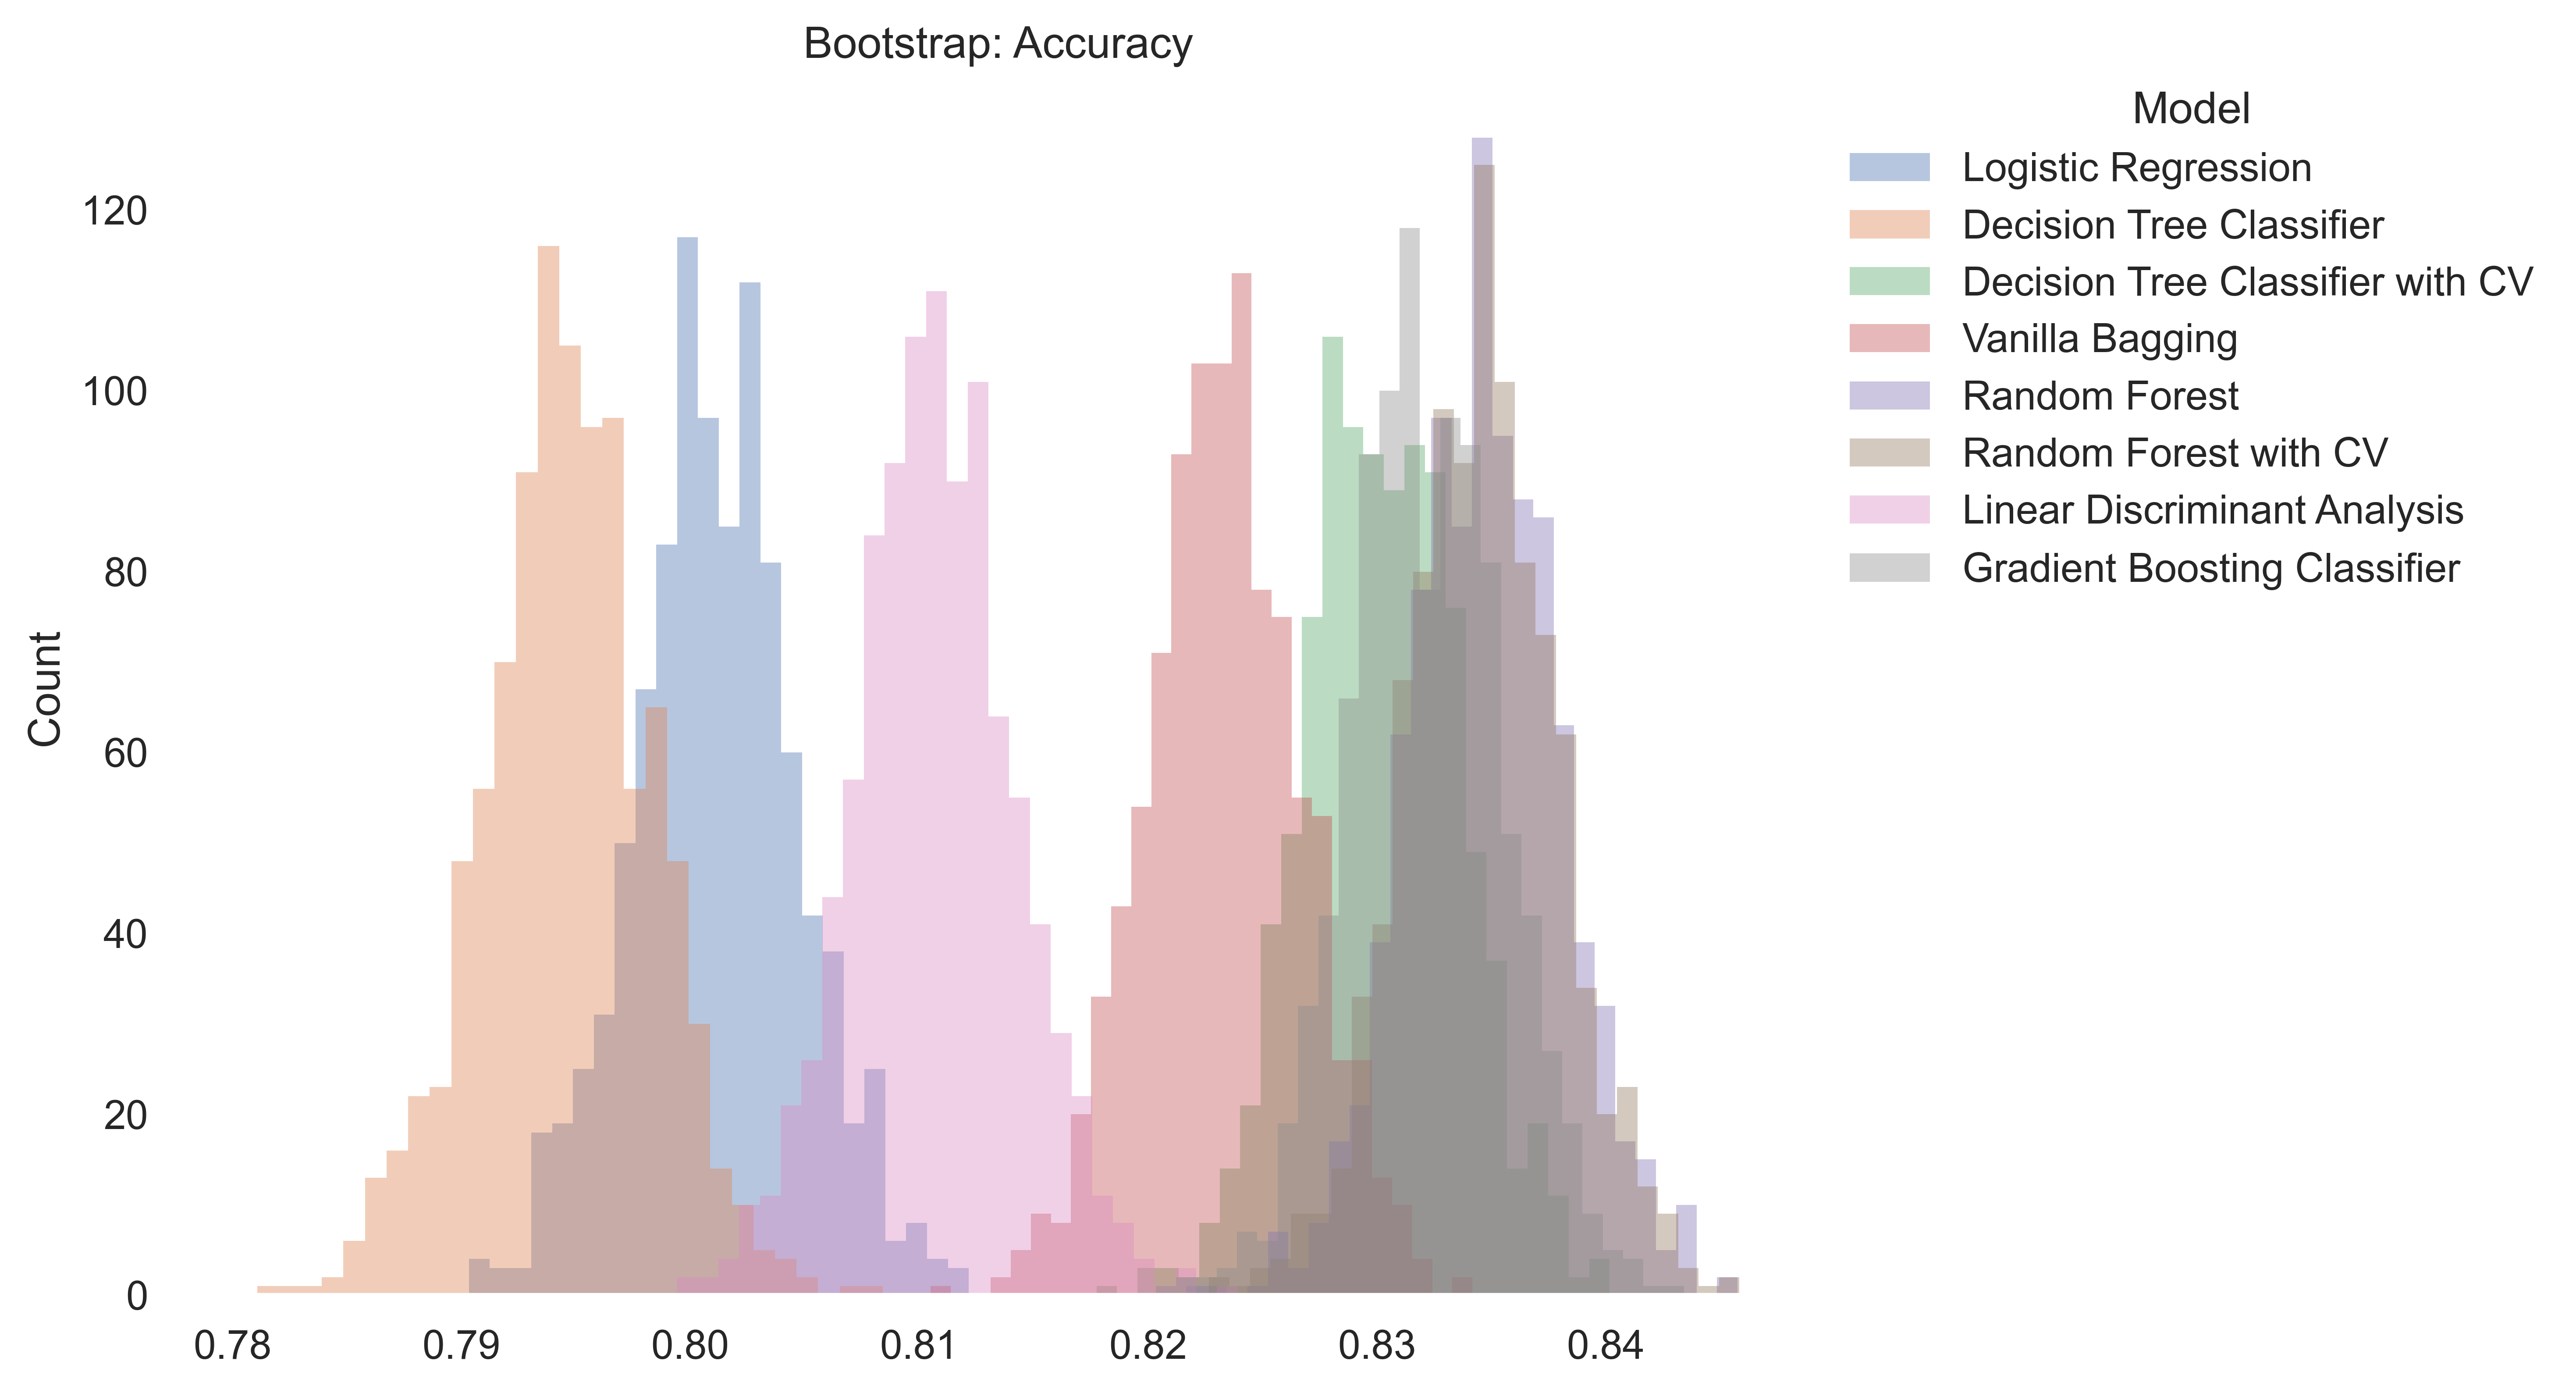

In [23]:
# Bootstrap: Accuracy
fig, ax = plt.subplots(nrows=1, ncols=1)
for i in range(len(bs)):
    sns.histplot(np.array(list(bs.values())[i])[:,0], edgecolor='none', 
                 color=sns.color_palette()[i], alpha=0.4, ax=ax);
plt.title('Bootstrap: Accuracy');
plt.legend(title='Model', labels=list(bs.keys()), 
           bbox_to_anchor=(1, 1.02), loc="upper left");
plt.grid(False);
ax.set_facecolor('white');

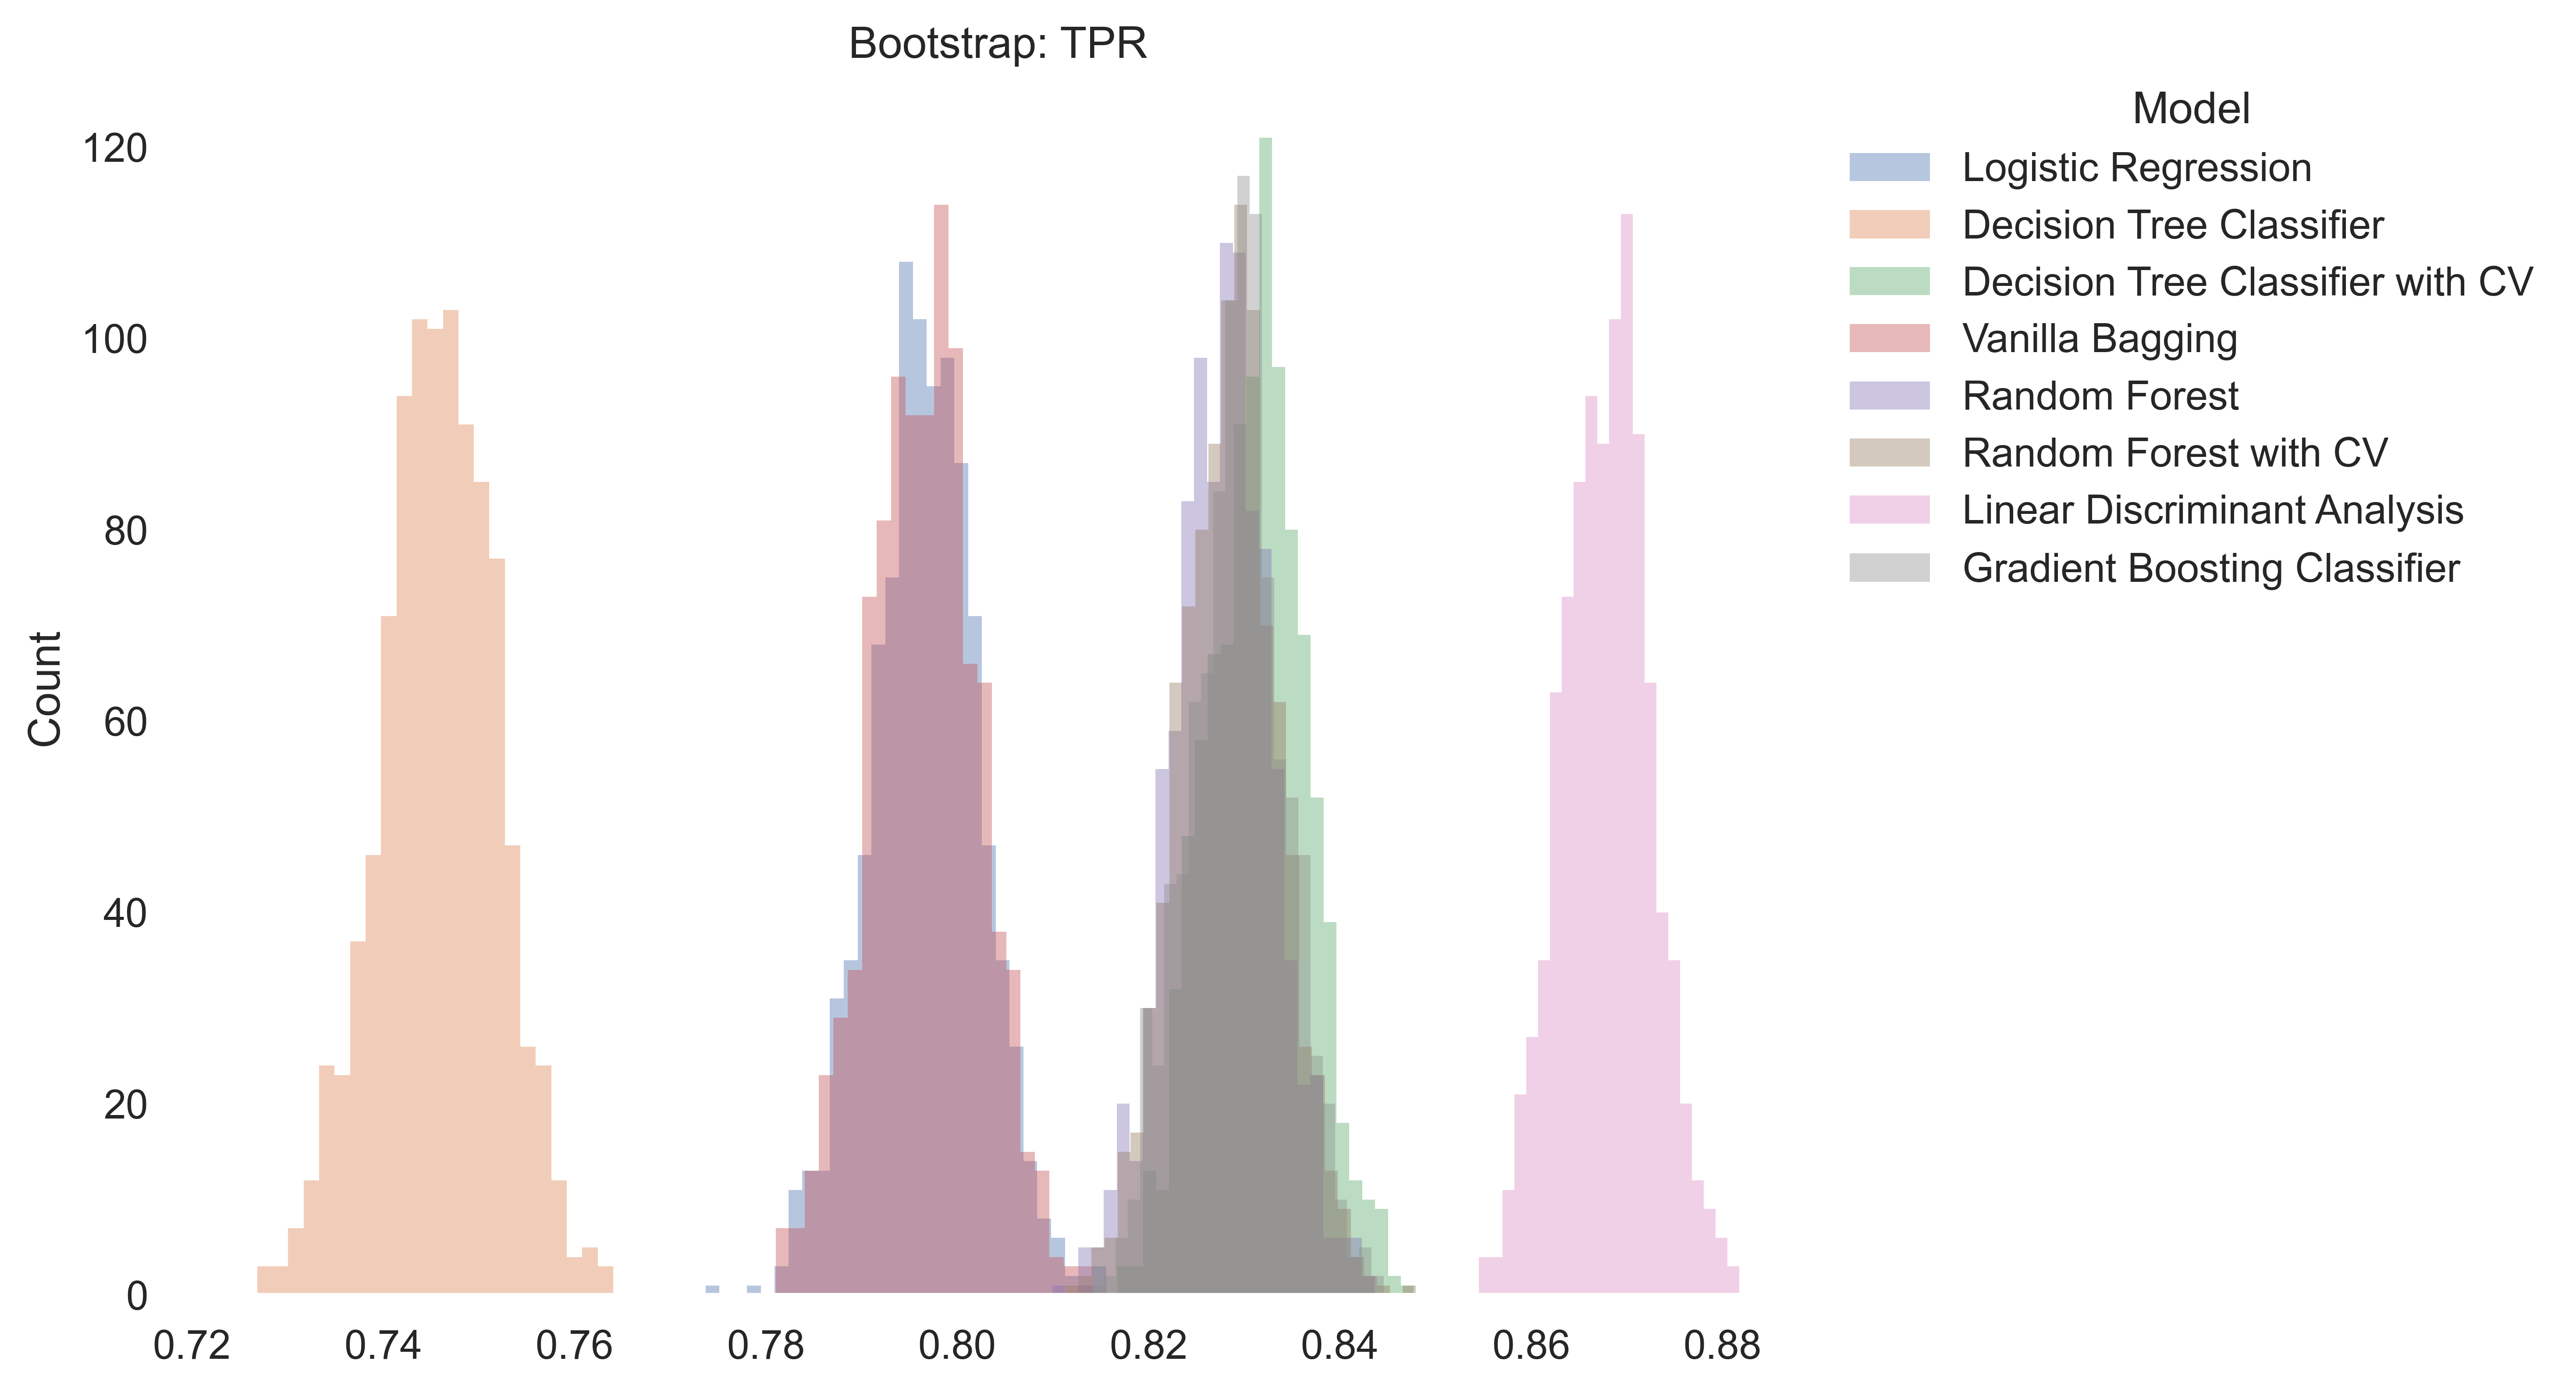

In [24]:
# Bootstrap: TPR
fig, ax = plt.subplots(nrows=1, ncols=1)
for i in range(len(bs)):
    sns.histplot(np.array(list(bs.values())[i])[:,1], edgecolor='none', 
                 color=sns.color_palette()[i], alpha=0.4, ax=ax);
plt.title('Bootstrap: TPR');
plt.legend(title='Model', labels=list(bs.keys()), 
           bbox_to_anchor=(1, 1.02), loc="upper left");
plt.grid(False);
ax.set_facecolor('white');

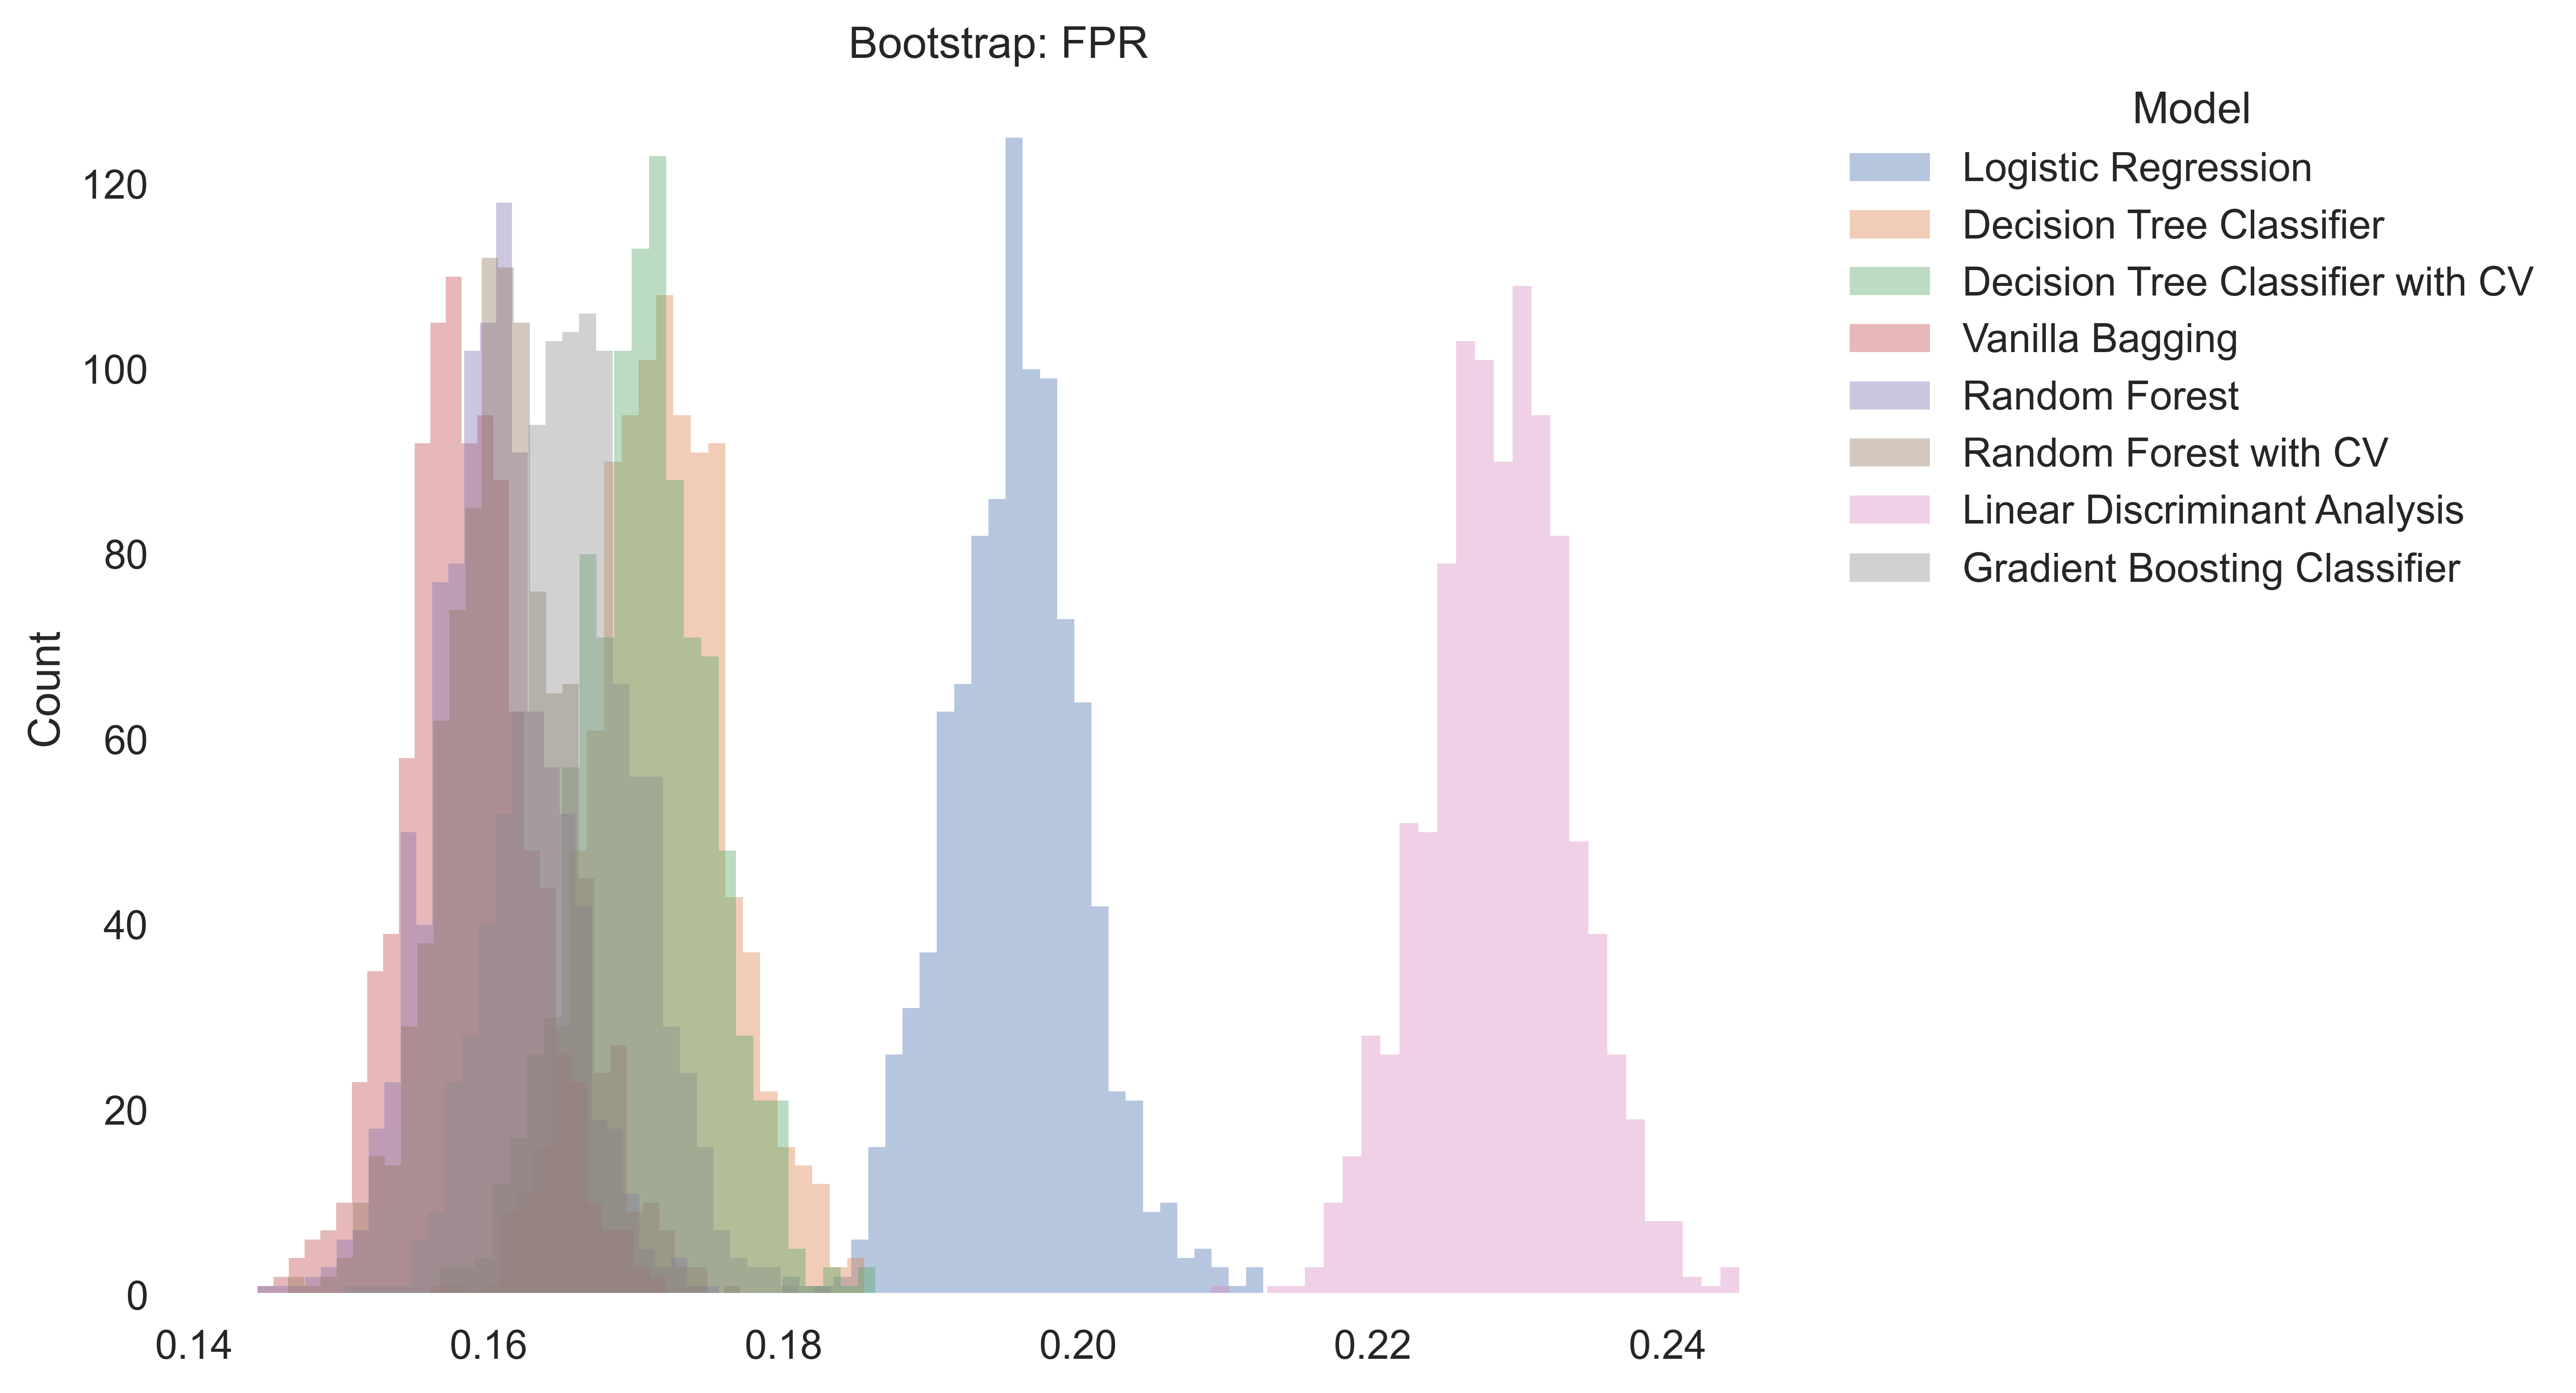

In [25]:
# Bootstrap: FPR
fig, ax = plt.subplots(nrows=1, ncols=1)
for i in range(len(bs)):
    sns.histplot(np.array(list(bs.values())[i])[:,2], edgecolor='none', 
                 color=sns.color_palette()[i], alpha=0.4, ax=ax);
plt.title('Bootstrap: FPR');
plt.legend(title='Model', labels=list(bs.keys()), 
           bbox_to_anchor=(1, 1.02), loc="upper left");
plt.grid(False);
ax.set_facecolor('white');

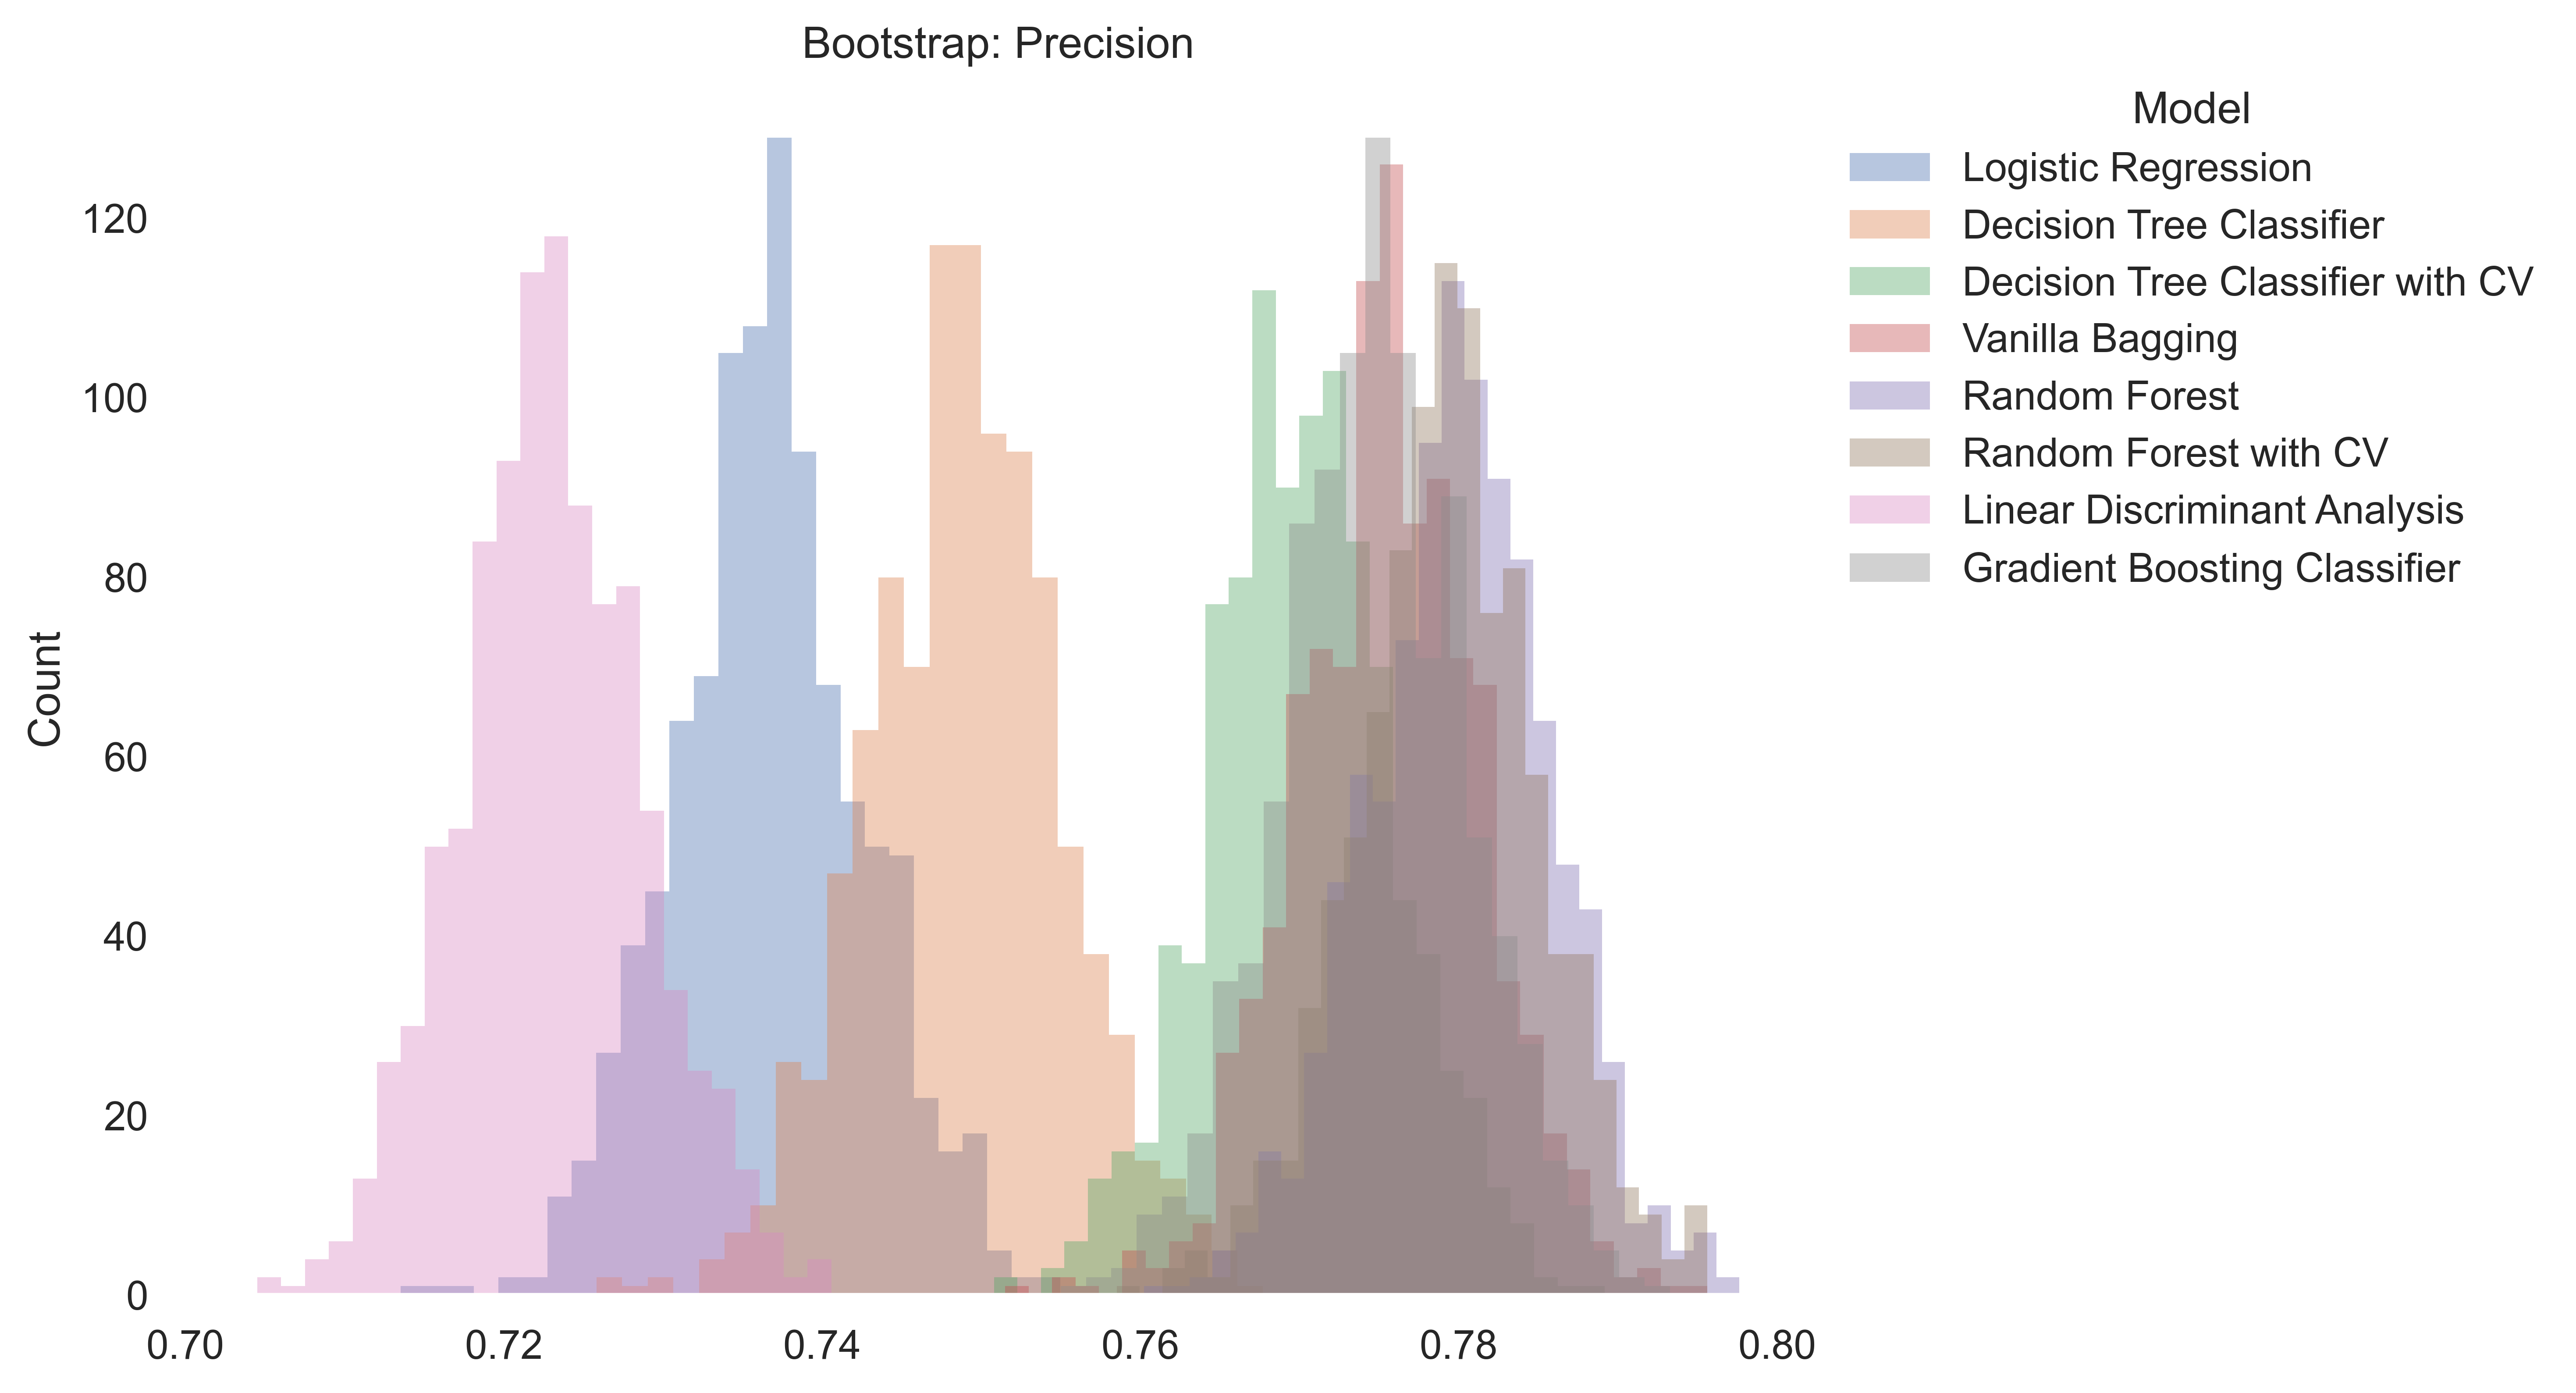

In [26]:
# Bootstrap: Precision
fig, ax = plt.subplots(nrows=1, ncols=1)
for i in range(len(bs)):
    sns.histplot(np.array(list(bs.values())[i])[:,3], edgecolor='none', 
                 color=sns.color_palette()[i], alpha=0.4, ax=ax);
plt.title('Bootstrap: Precision');
plt.legend(title='Model', labels=list(bs.keys()), 
           bbox_to_anchor=(1, 1.02), loc="upper left");
plt.grid(False);
ax.set_facecolor('white');

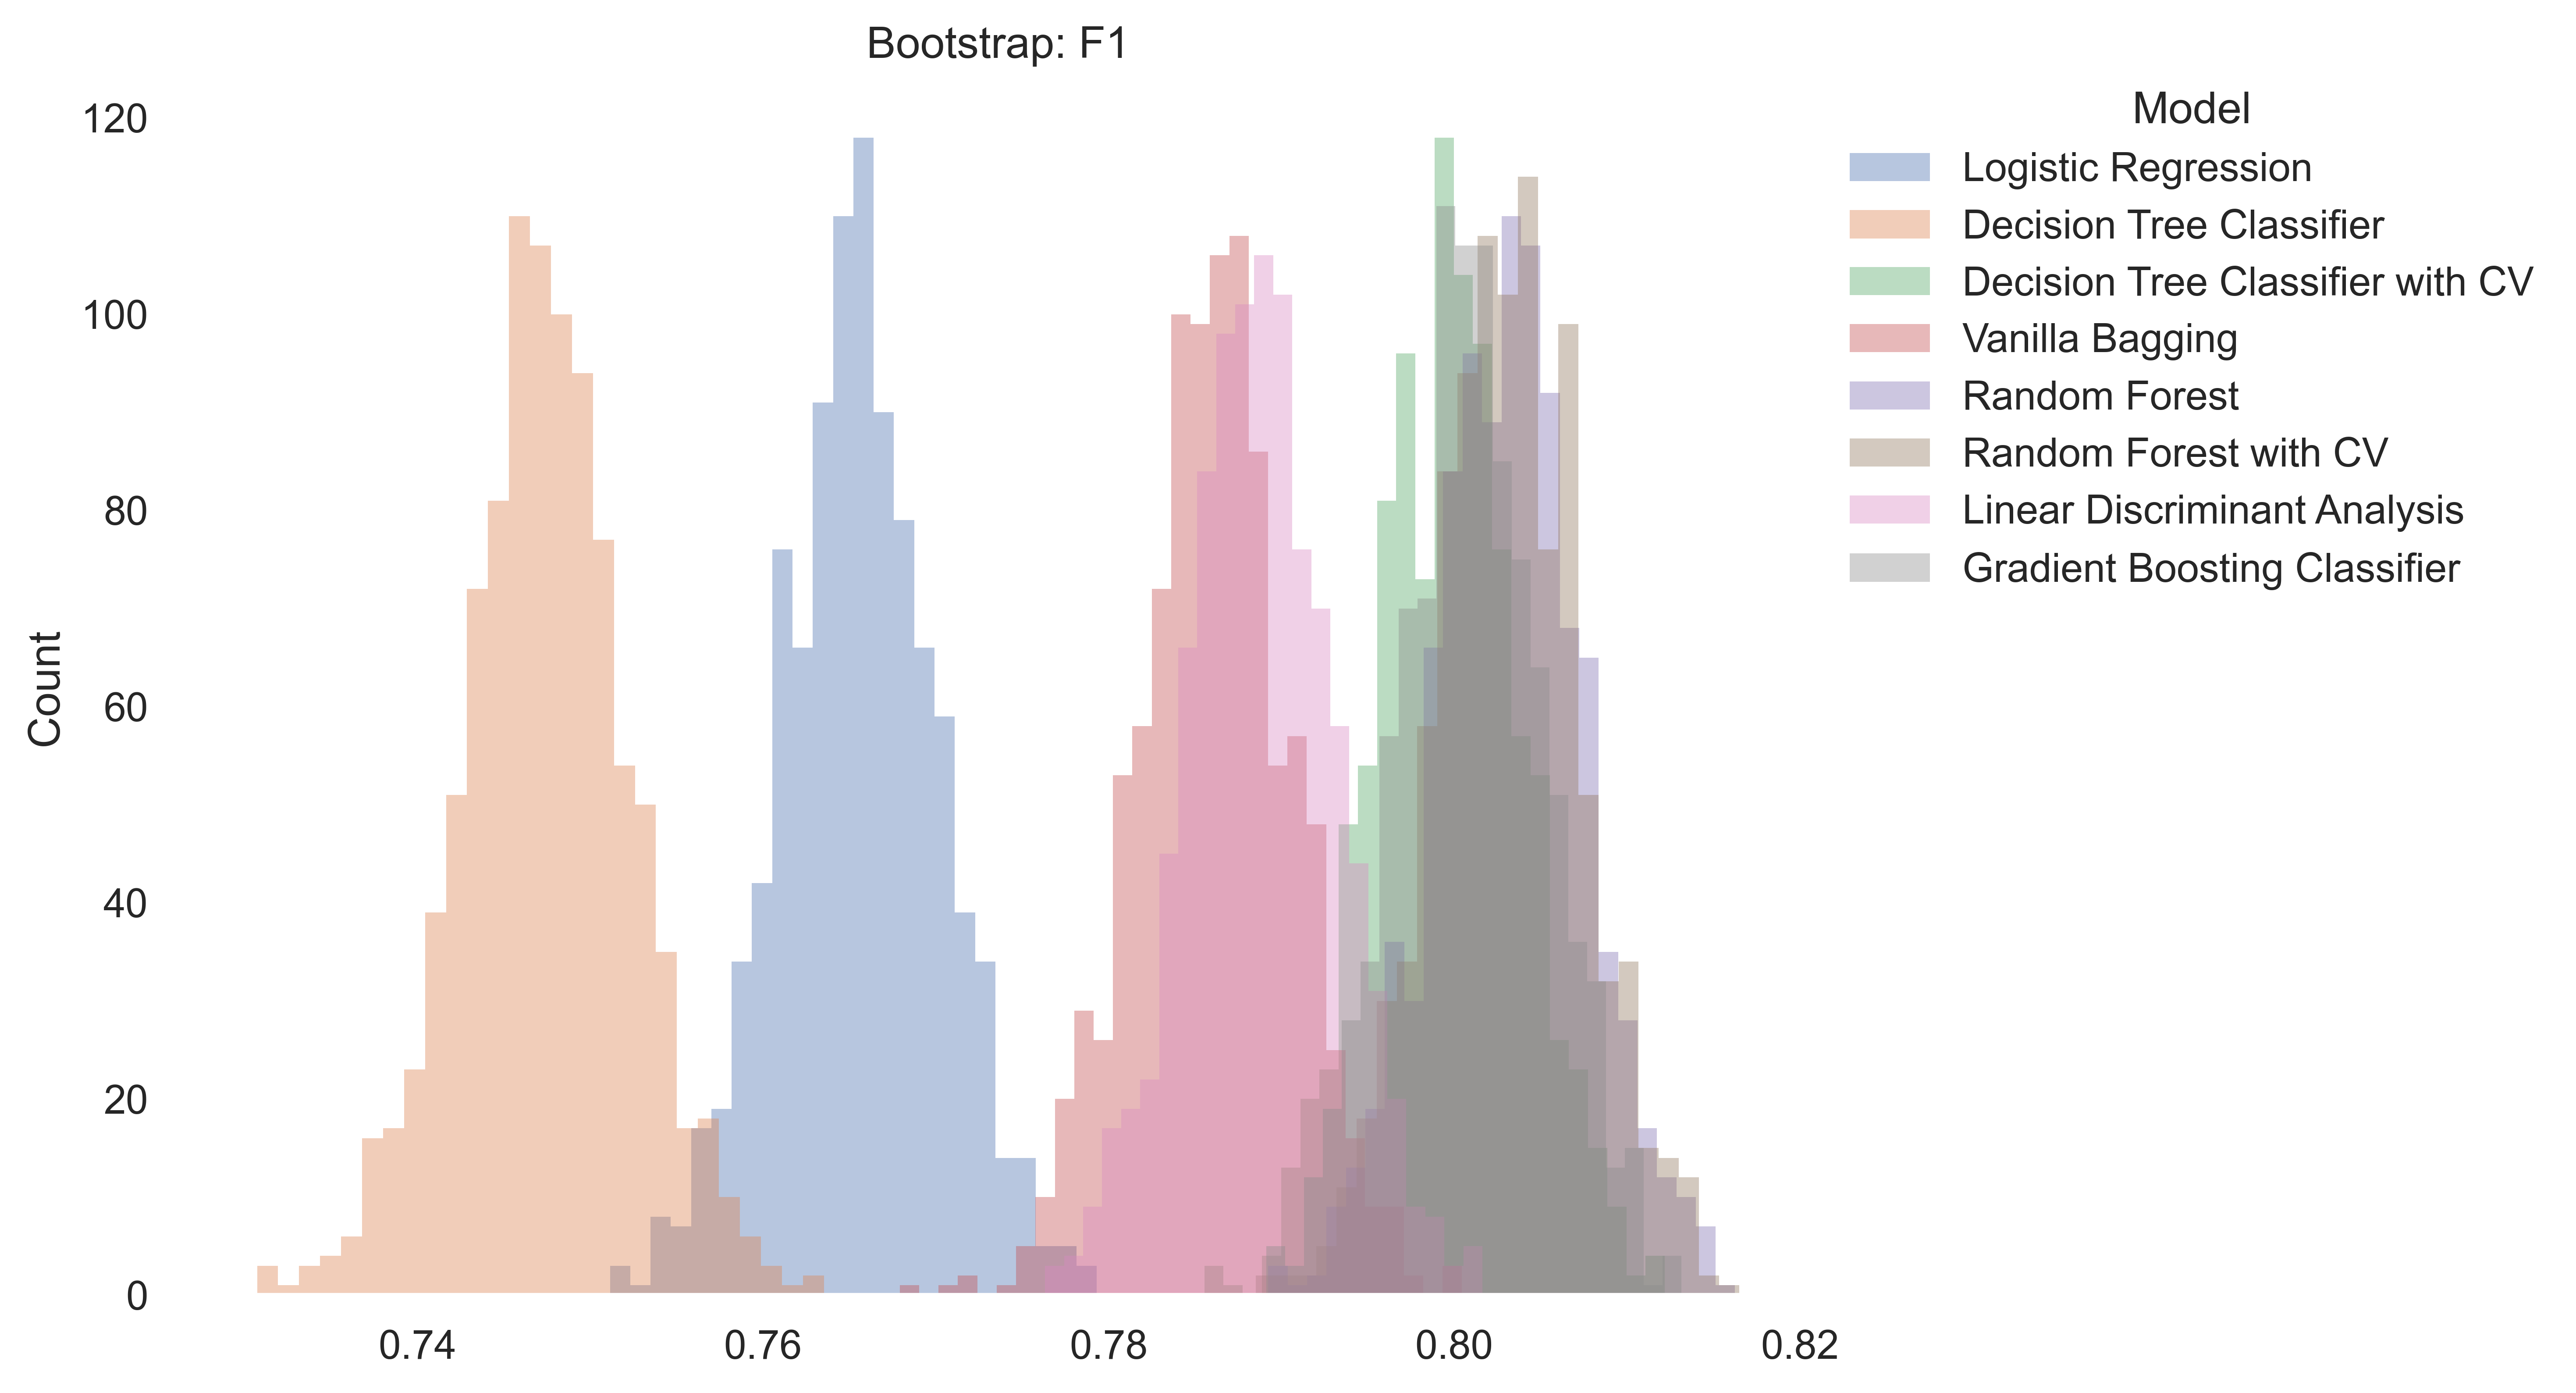

In [27]:
# Bootstrap: F1
fig, ax = plt.subplots(nrows=1, ncols=1)
for i in range(len(bs)):
    sns.histplot(np.array(list(bs.values())[i])[:,4], edgecolor='none', 
                 color=sns.color_palette()[i], alpha=0.4, ax=ax);
plt.title('Bootstrap: F1');
plt.legend(title='Model', labels=list(bs.keys()), 
           bbox_to_anchor=(1, 1.02), loc="upper left");
plt.grid(False);
ax.set_facecolor('white');

# Confidence Interval

In [28]:
metric = ['Accuracy','TPR','FPR','Precision','F1']
for i in range(len(metric)):
    print(f'{metric[i]}')
    df1=pd.DataFrame()
    for m in list(bs.keys()):
        met = np.array(bs[m])[:,i]
        df2 = pd.DataFrame(
                {'model':[m],
                 '95% CI':[np.round(np.quantile(met, np.array([0.025,0.975])), 4)],
                 'mean':[np.mean(met)],
                 'sd':[np.std(met)]
                })
        df1 = pd.concat([df1,df2], ignore_index=True)
    display(df1.sort_values(['mean'], ascending=False))

Accuracy


model            95% CI      mean        sd
4                     Random Forest  [0.8281, 0.8417]  0.834772  0.003382
5             Random Forest with CV  [0.8277, 0.8414]  0.834555  0.003412
7      Gradient Boosting Classifier  [0.8259, 0.8386]  0.832166  0.003337
2  Decision Tree Classifier with CV  [0.8237, 0.8369]  0.830213  0.003378
3                   Vanilla Bagging  [0.8167, 0.8299]  0.823267  0.003403
6      Linear Discriminant Analysis  [0.8038, 0.8177]  0.810705  0.003537
0               Logistic Regression  [0.7938, 0.8083]  0.801156  0.003599
1          Decision Tree Classifier  [0.7868, 0.8017]  0.794588  0.003698

TPR


model            95% CI      mean        sd
6      Linear Discriminant Analysis  [0.8588, 0.8775]  0.867886  0.004697
2  Decision Tree Classifier with CV  [0.8218, 0.8419]  0.831477  0.005150
7      Gradient Boosting Classifier  [0.8193, 0.8393]  0.829365  0.005052
5             Random Forest with CV  [0.8179, 0.8386]  0.828436  0.005275
4                     Random Forest   [0.8171, 0.838]  0.827714  0.005260
0               Logistic Regression  [0.7851, 0.8081]  0.796710  0.005722
3                   Vanilla Bagging  [0.7853, 0.8077]  0.796700  0.005719
1          Decision Tree Classifier  [0.7334, 0.7575]  0.745809  0.006156

FPR


model            95% CI      mean        sd
6      Linear Discriminant Analysis   [0.219, 0.2381]  0.228610  0.004936
0               Logistic Regression  [0.1867, 0.2056]  0.195788  0.004680
1          Decision Tree Classifier  [0.1632, 0.1814]  0.171872  0.004442
2  Decision Tree Classifier with CV  [0.1617, 0.1796]  0.170655  0.004513
7      Gradient Boosting Classifier  [0.1575, 0.1747]  0.165907  0.004451
5             Random Forest with CV  [0.1524, 0.1703]  0.161236  0.004368
4                     Random Forest  [0.1522, 0.1691]  0.160373  0.004322
3                   Vanilla Bagging  [0.1501, 0.1671]  0.158465  0.004233

Precision


model            95% CI      mean        sd
4                     Random Forest  [0.7683, 0.7916]  0.780151  0.005804
5             Random Forest with CV  [0.7674, 0.7908]  0.779380  0.005817
3                   Vanilla Bagging  [0.7646, 0.7869]  0.775621  0.005811
7      Gradient Boosting Classifier  [0.7628, 0.7861]  0.774628  0.005826
2  Decision Tree Classifier with CV  [0.7584, 0.7817]  0.770115  0.005800
1          Decision Tree Classifier  [0.7371, 0.7617]  0.748966  0.006198
0               Logistic Regression  [0.7251, 0.7489]  0.736693  0.005971
6      Linear Discriminant Analysis  [0.7118, 0.7346]  0.723008  0.005772

F1


model            95% CI      mean        sd
4                     Random Forest  [0.7947, 0.8121]  0.803213  0.004325
5             Random Forest with CV  [0.7945, 0.8122]  0.803144  0.004340
7      Gradient Boosting Classifier  [0.7928, 0.8095]  0.801047  0.004222
2  Decision Tree Classifier with CV  [0.7913, 0.8084]  0.799604  0.004240
6      Linear Discriminant Analysis   [0.7802, 0.797]  0.788836  0.004261
3                   Vanilla Bagging  [0.7773, 0.7946]  0.786002  0.004461
0               Logistic Regression  [0.7564, 0.7748]  0.765510  0.004618
1          Decision Tree Classifier  [0.7374, 0.7573]  0.747365  0.004886

# Best Models Based on Precision and TPR

In [29]:
best = ['Decision Tree Classifier with CV',
        'Random Forest',
        'Random Forest with CV',
        'Gradient Boosting Classifier']

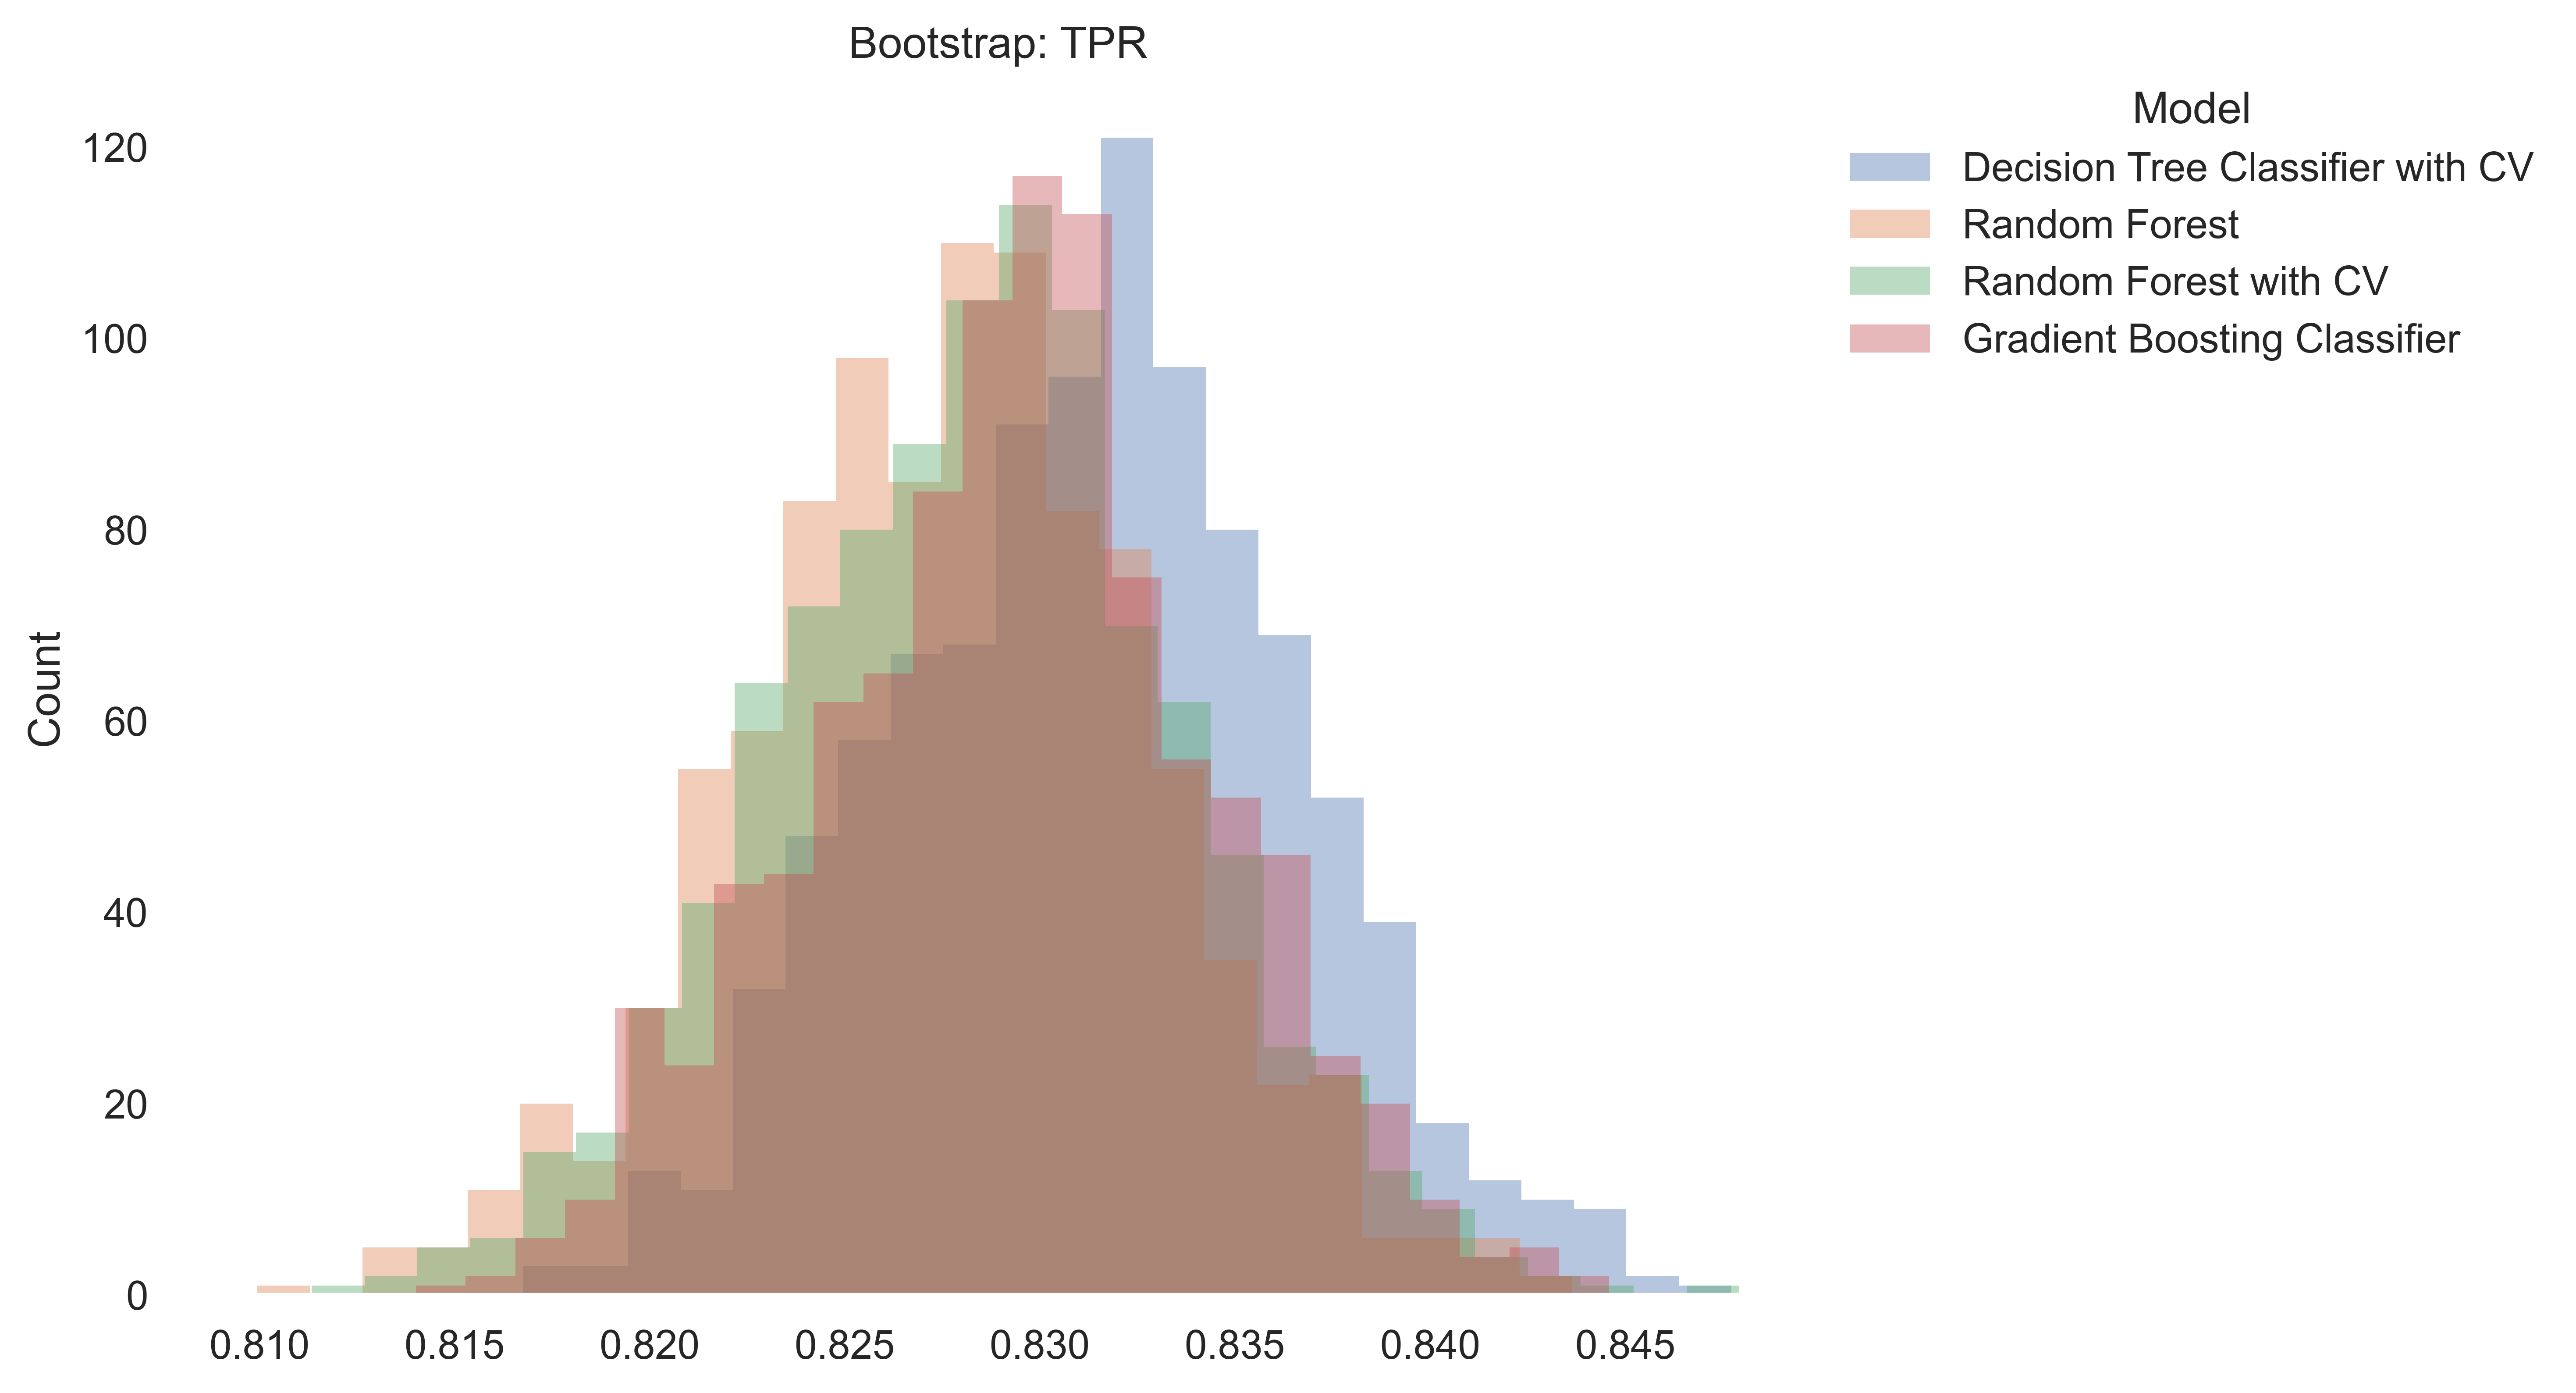

In [30]:
# Bootstrap: TPR
fig, ax = plt.subplots(nrows=1, ncols=1)
for i in range(len(best)):
    sns.histplot(np.array(bs[best[i]])[:,1], edgecolor='none', 
                 color=sns.color_palette()[i], alpha=0.4, ax=ax);
plt.title('Bootstrap: TPR');
plt.legend(title='Model', labels=best, 
           bbox_to_anchor=(1, 1.02), loc="upper left");
plt.grid(False);
ax.set_facecolor('white');

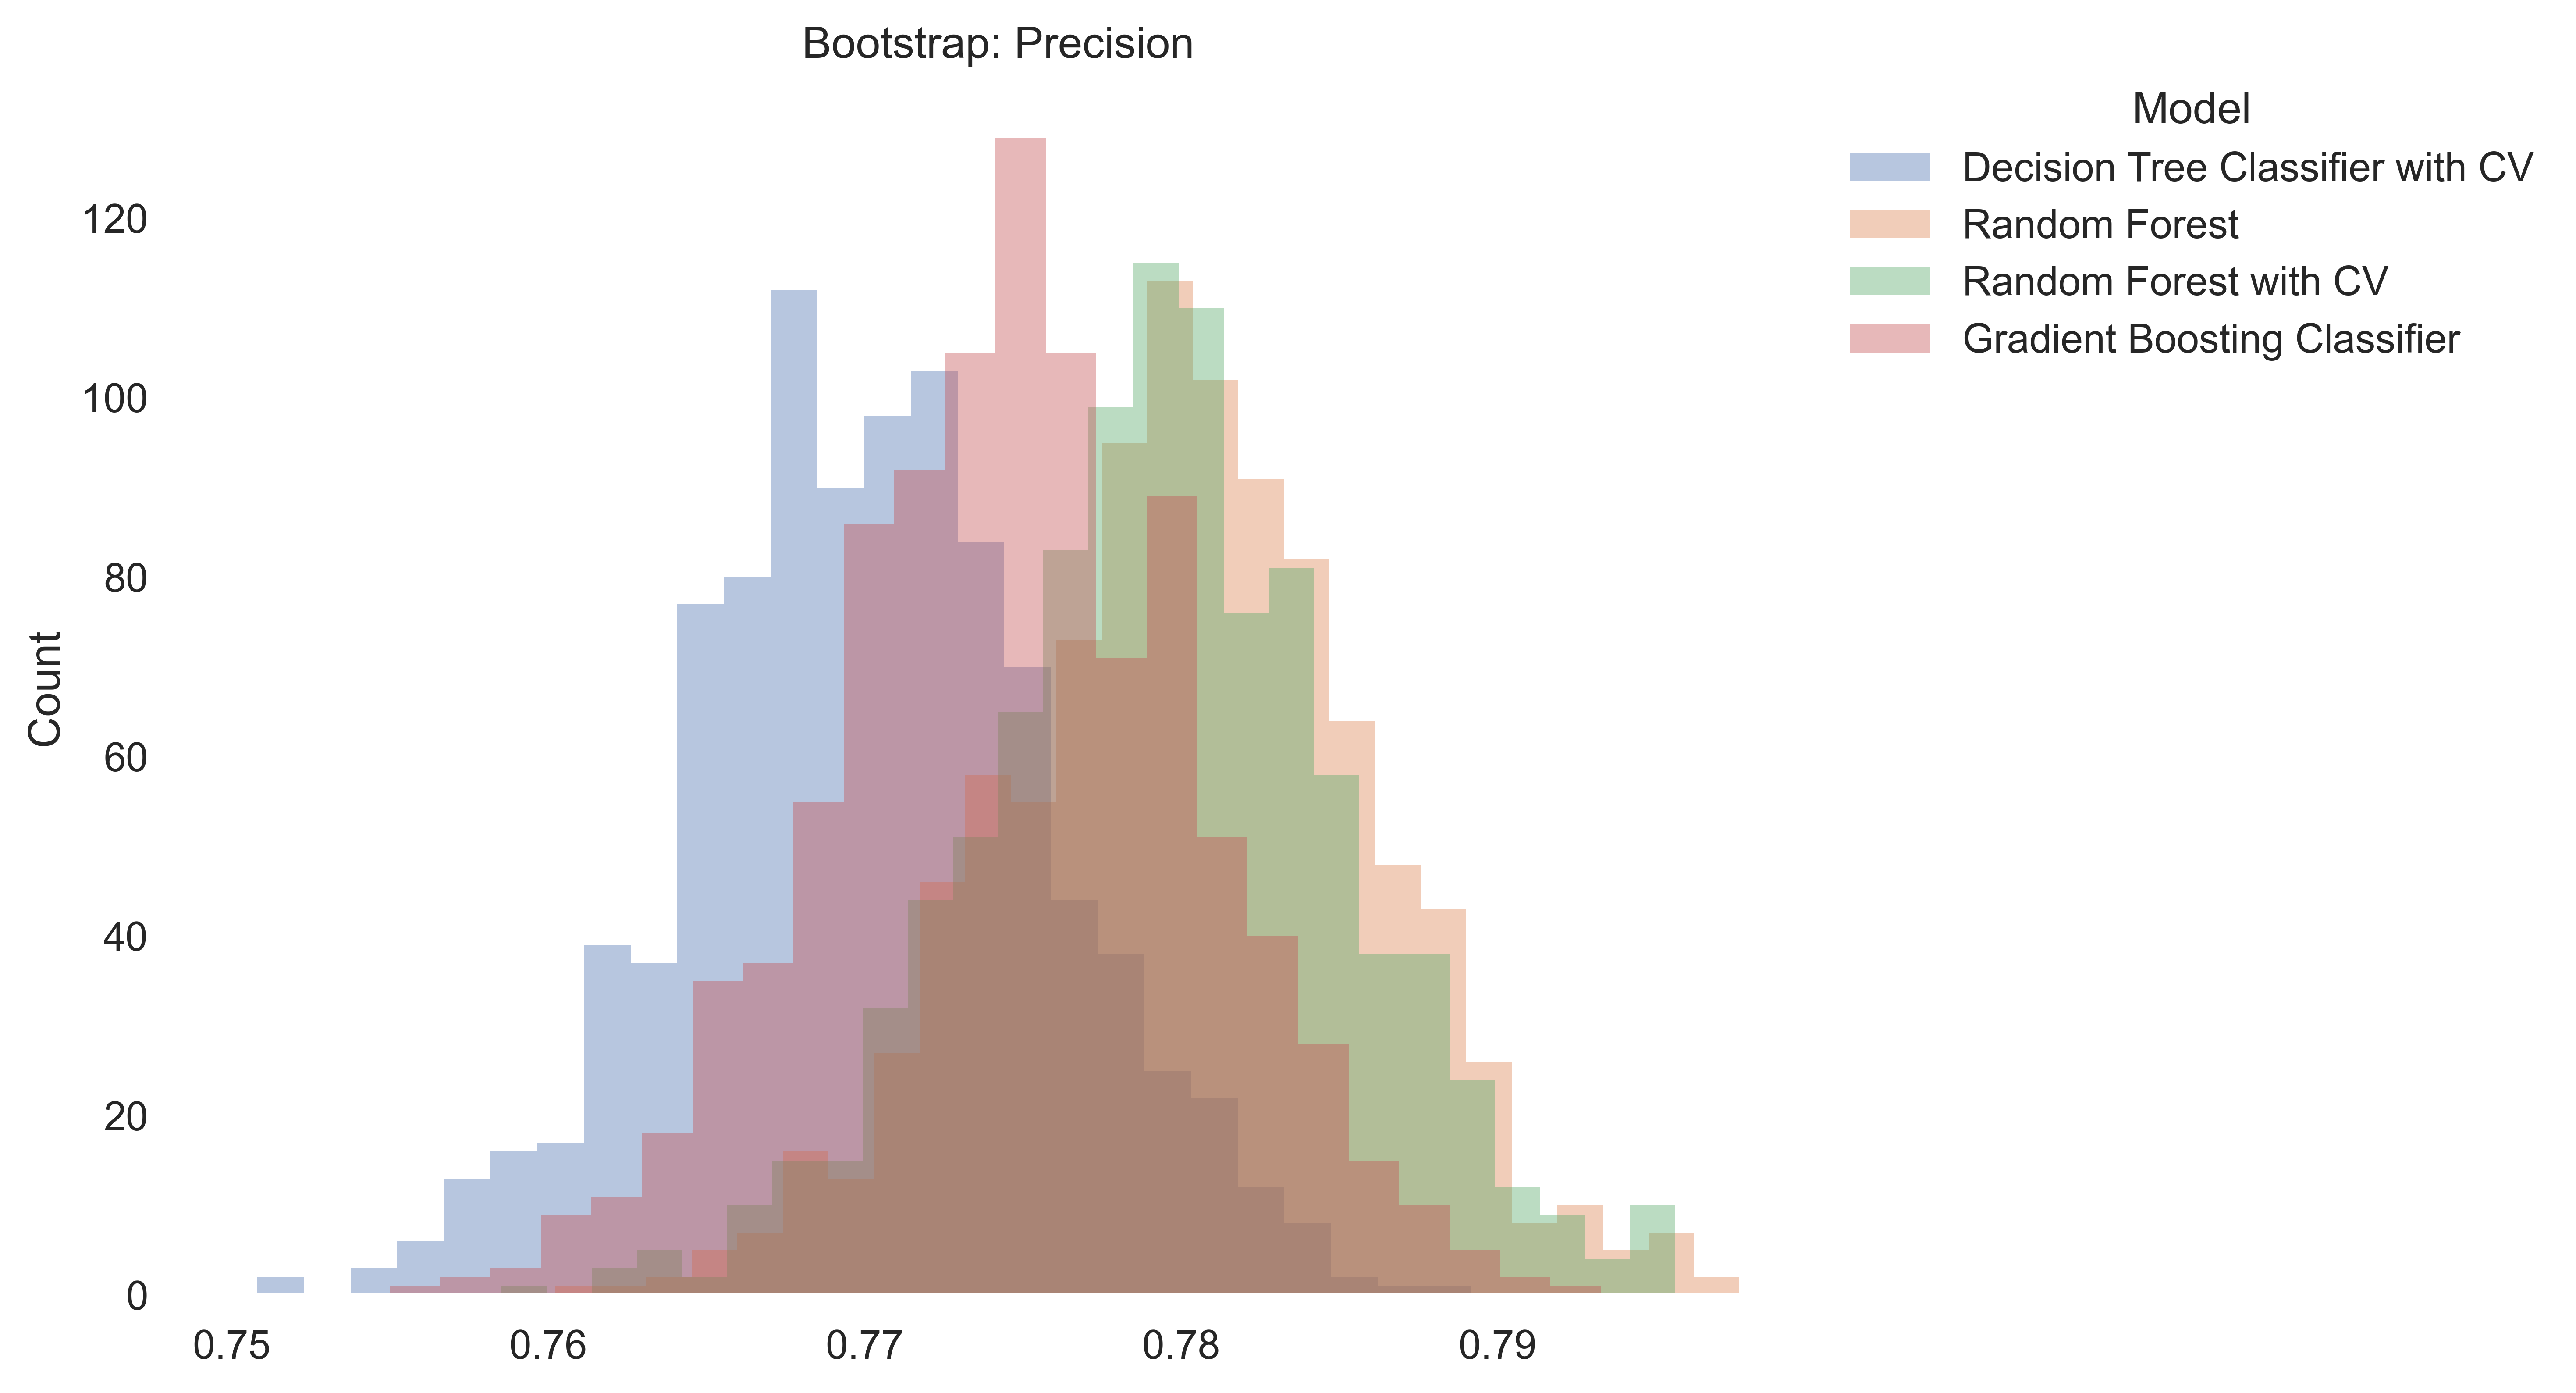

In [31]:
# Bootstrap: Precision
fig, ax = plt.subplots(nrows=1, ncols=1)
for i in range(len(best)):
    sns.histplot(np.array(bs[best[i]])[:,3], edgecolor='none', 
                 color=sns.color_palette()[i], alpha=0.4, ax=ax);
plt.title('Bootstrap: Precision');
plt.legend(title='Model', labels=best, 
           bbox_to_anchor=(1, 1.02), loc="upper left");
plt.grid(False);
ax.set_facecolor('white');

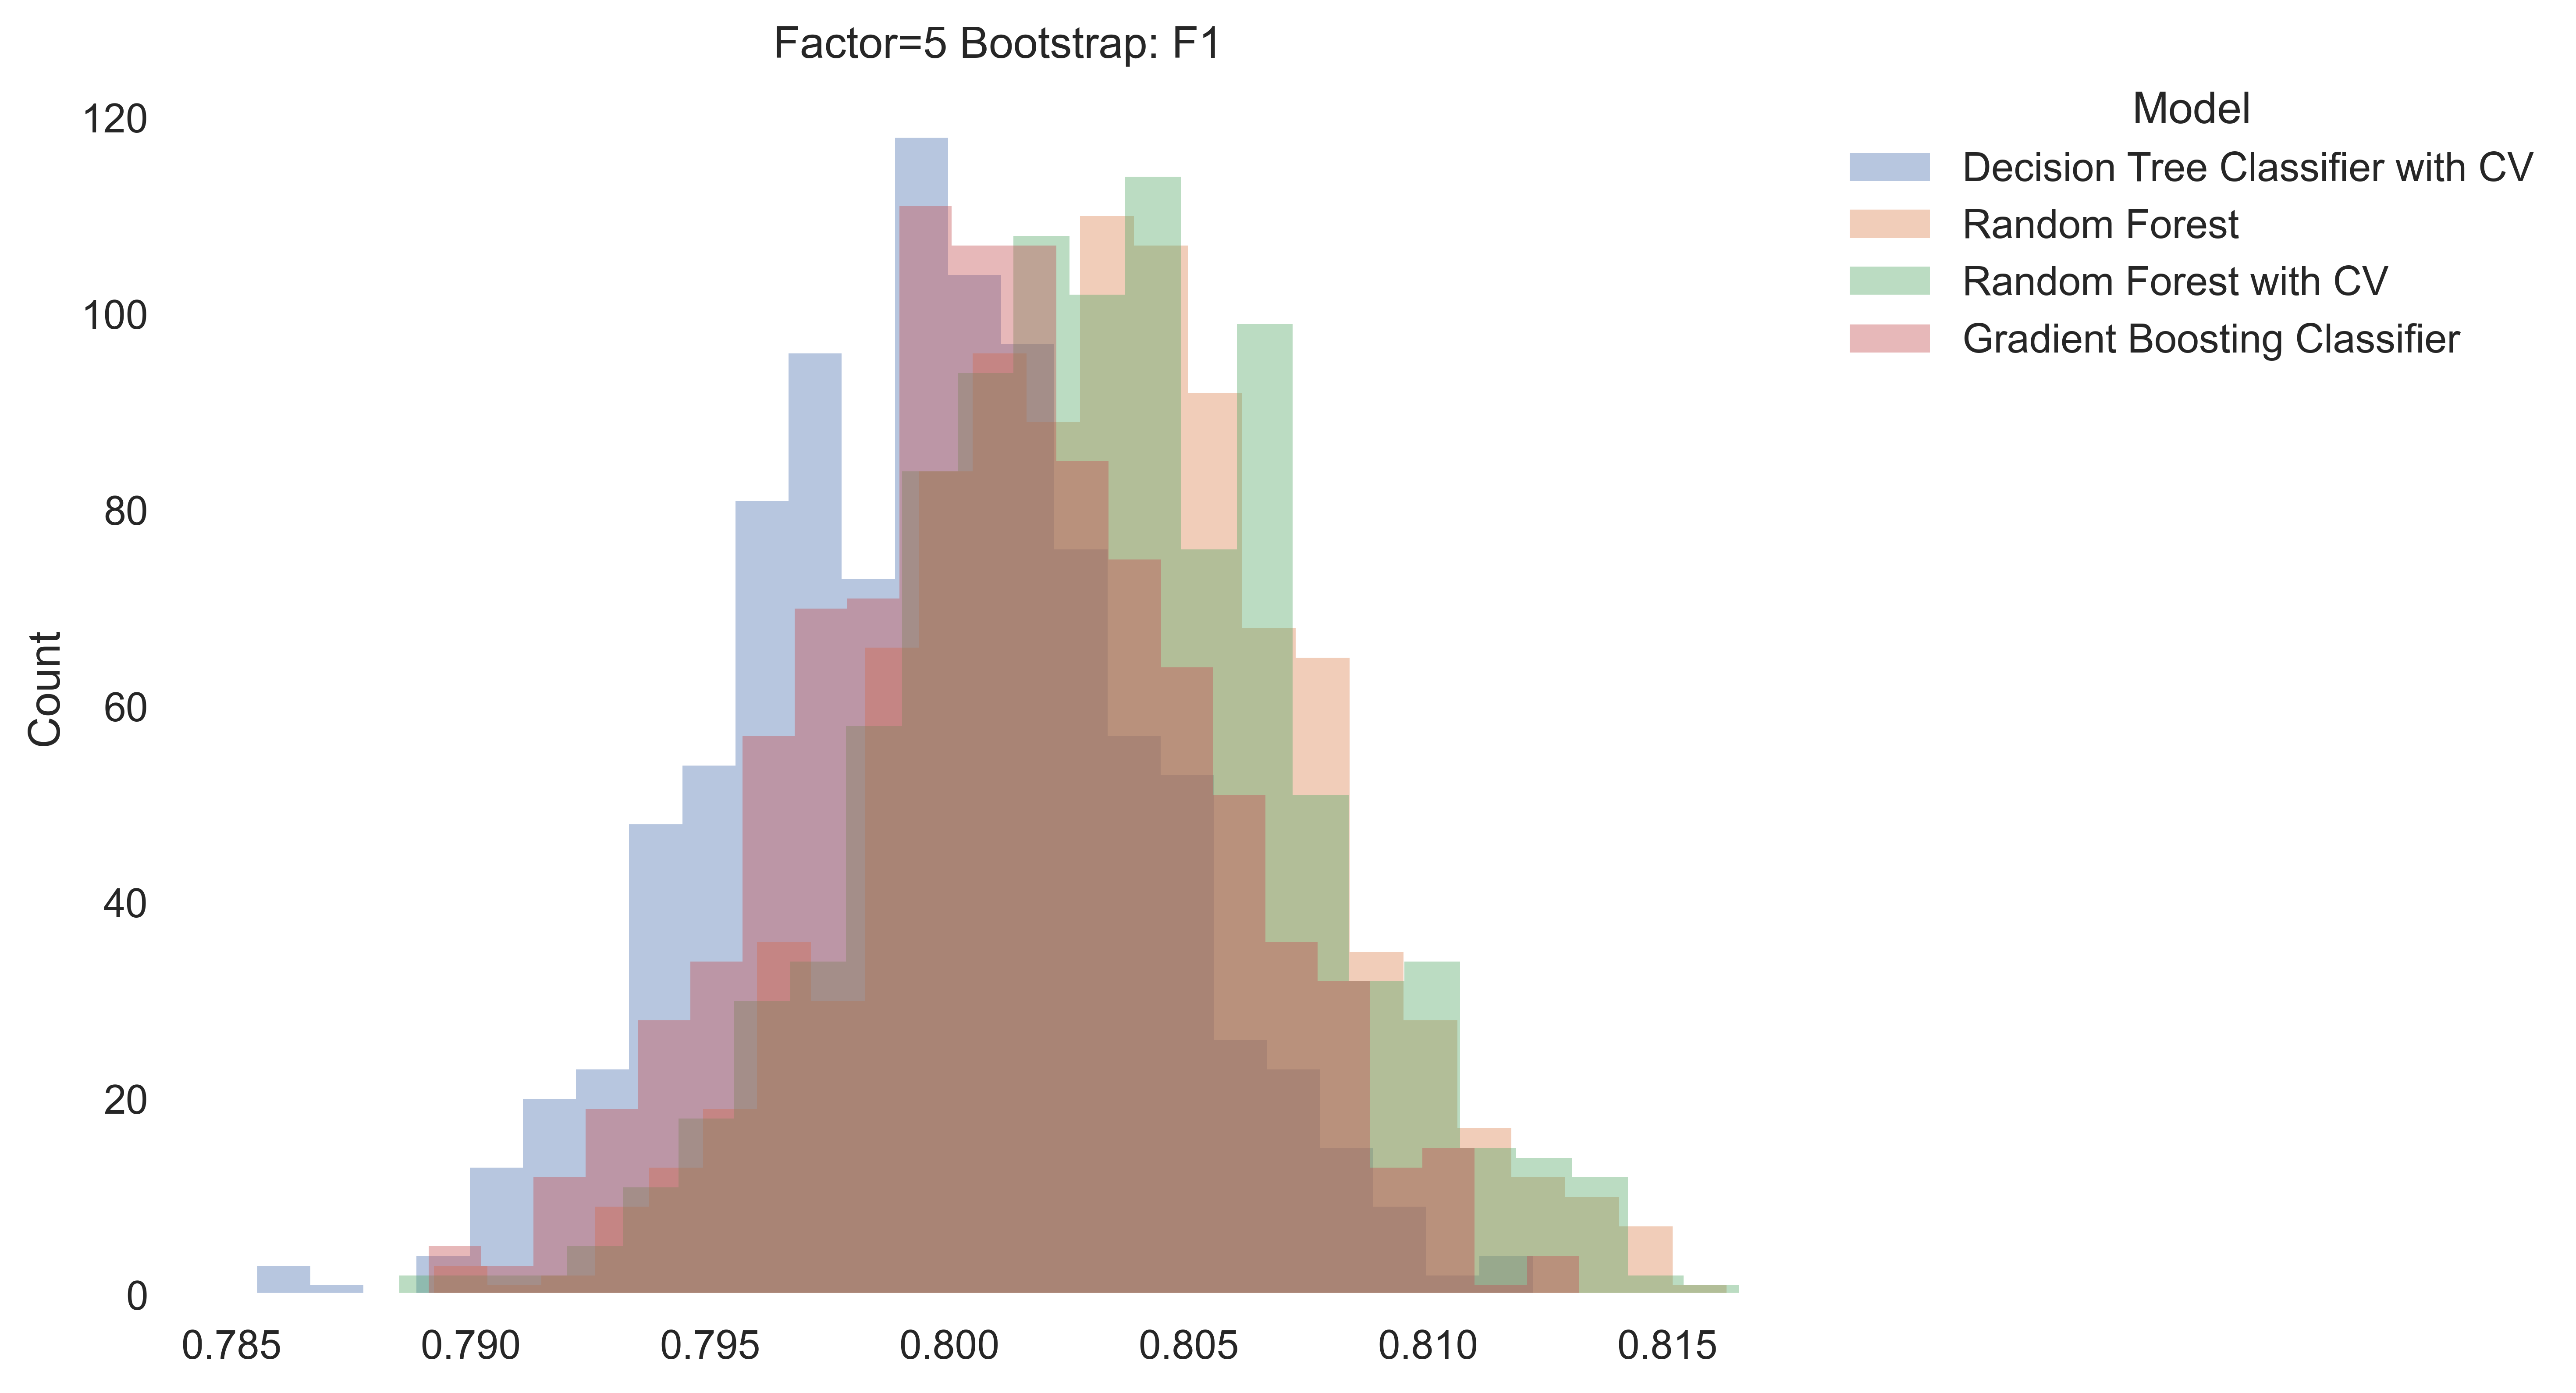

In [32]:
# Bootstrap: F1
fig, ax = plt.subplots(nrows=1, ncols=1)
for i in range(len(best)):
    sns.histplot(np.array(bs[best[i]])[:,4], edgecolor='none', 
                 color=sns.color_palette()[i], alpha=0.4, ax=ax);
plt.title('Factor=5 Bootstrap: F1');
plt.legend(title='Model', labels=best, 
           bbox_to_anchor=(1, 1.02), loc="upper left");
plt.grid(False);
ax.set_facecolor('white');

# ROC and Precision-Recall

In [33]:
models = {
          'Decision Tree Classifier with CV':dtc_cv,
          'Random Forest':rf,
          'Random Forest with CV':rf_cv,
          'Gradient Boosting Classifier':gbc,
          }

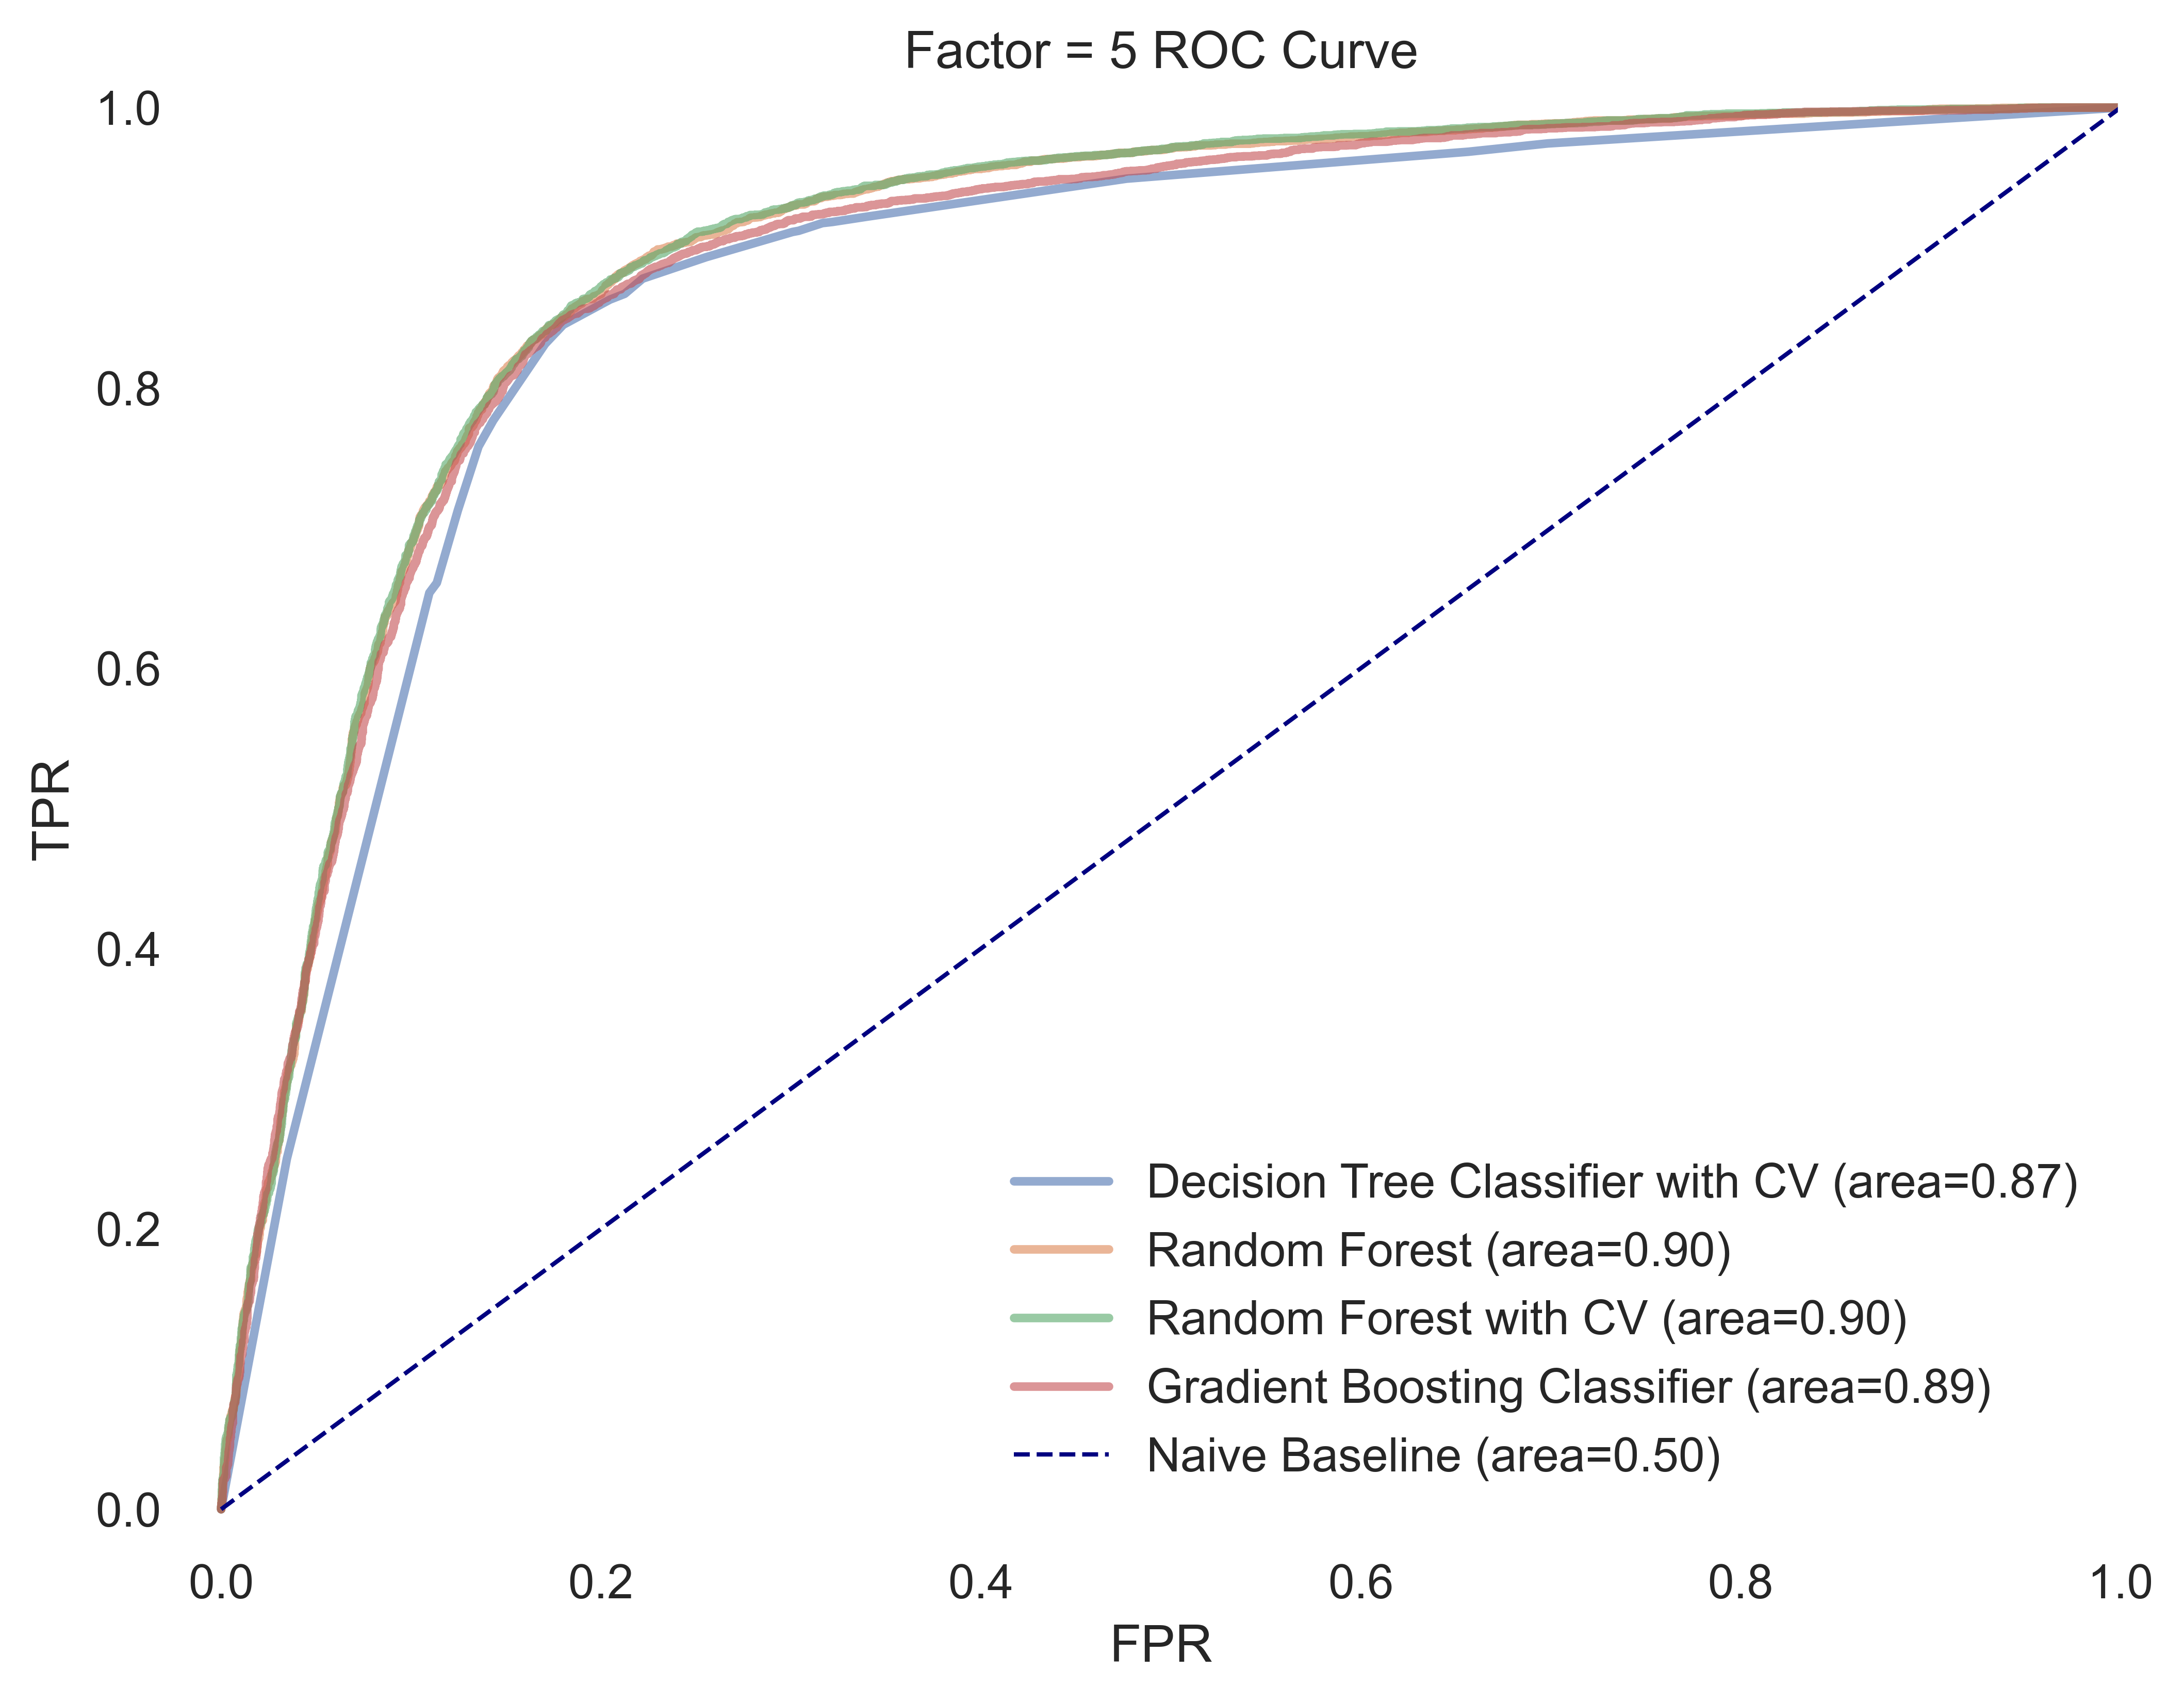

In [34]:
plt.rcParams['axes.facecolor']='white'
fig, ax = plt.subplots(nrows=1, ncols=1)
for m in range(len(models)):
    y_prob = list(models.values())[m].predict_proba(X_test)[:,1]
    y_pred = list(models.values())[m].predict(X_test)
    fpr, tpr, threshold = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, alpha=0.6,
            label=f'{list(models.keys())[m]} (area={roc_auc:0.2f})')
ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', 
             label='Naive Baseline (area=0.50)')
ax.legend(loc='lower right')
plt.title('Factor = 5 ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.show()

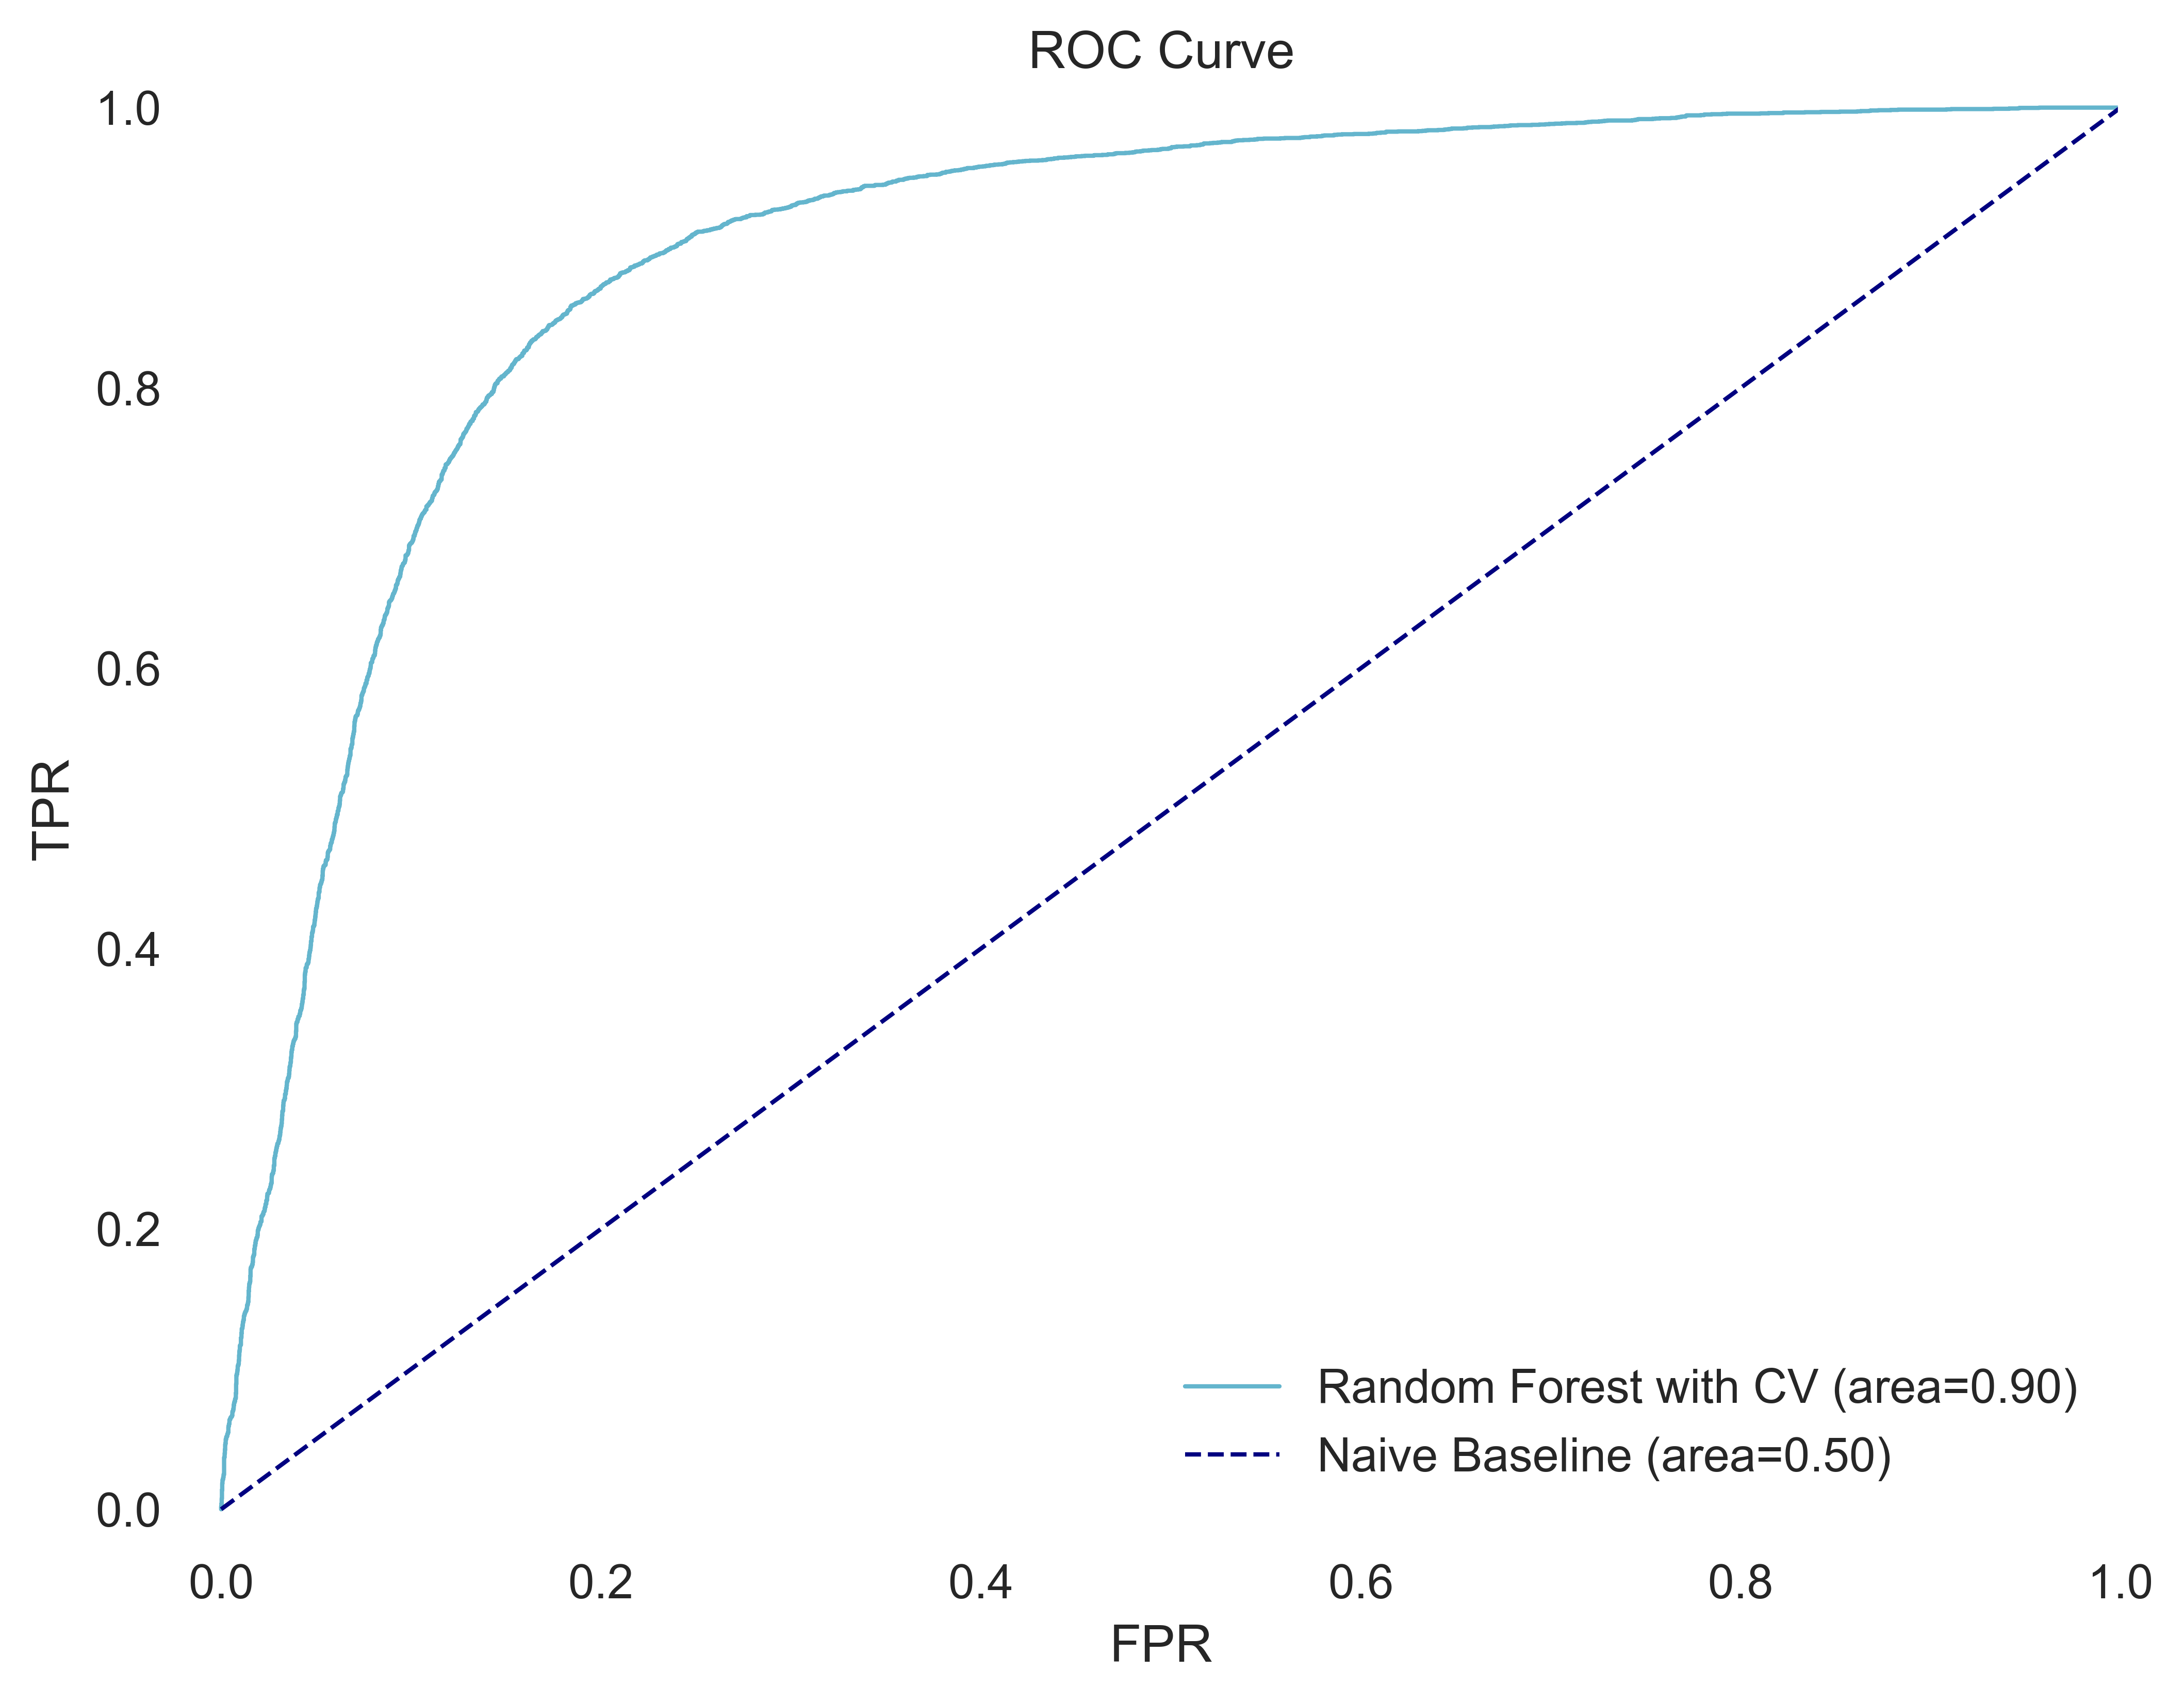

In [35]:
y_prob = rf_cv.predict_proba(X_test)[:,1]
y_pred = rf_cv.predict(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)


plt.plot(fpr, tpr, lw=1, color='c', 
         label=f'Random Forest with CV (area={roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', 
         label='Naive Baseline (area=0.50)')
plt.legend(loc='lower right')
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.show()

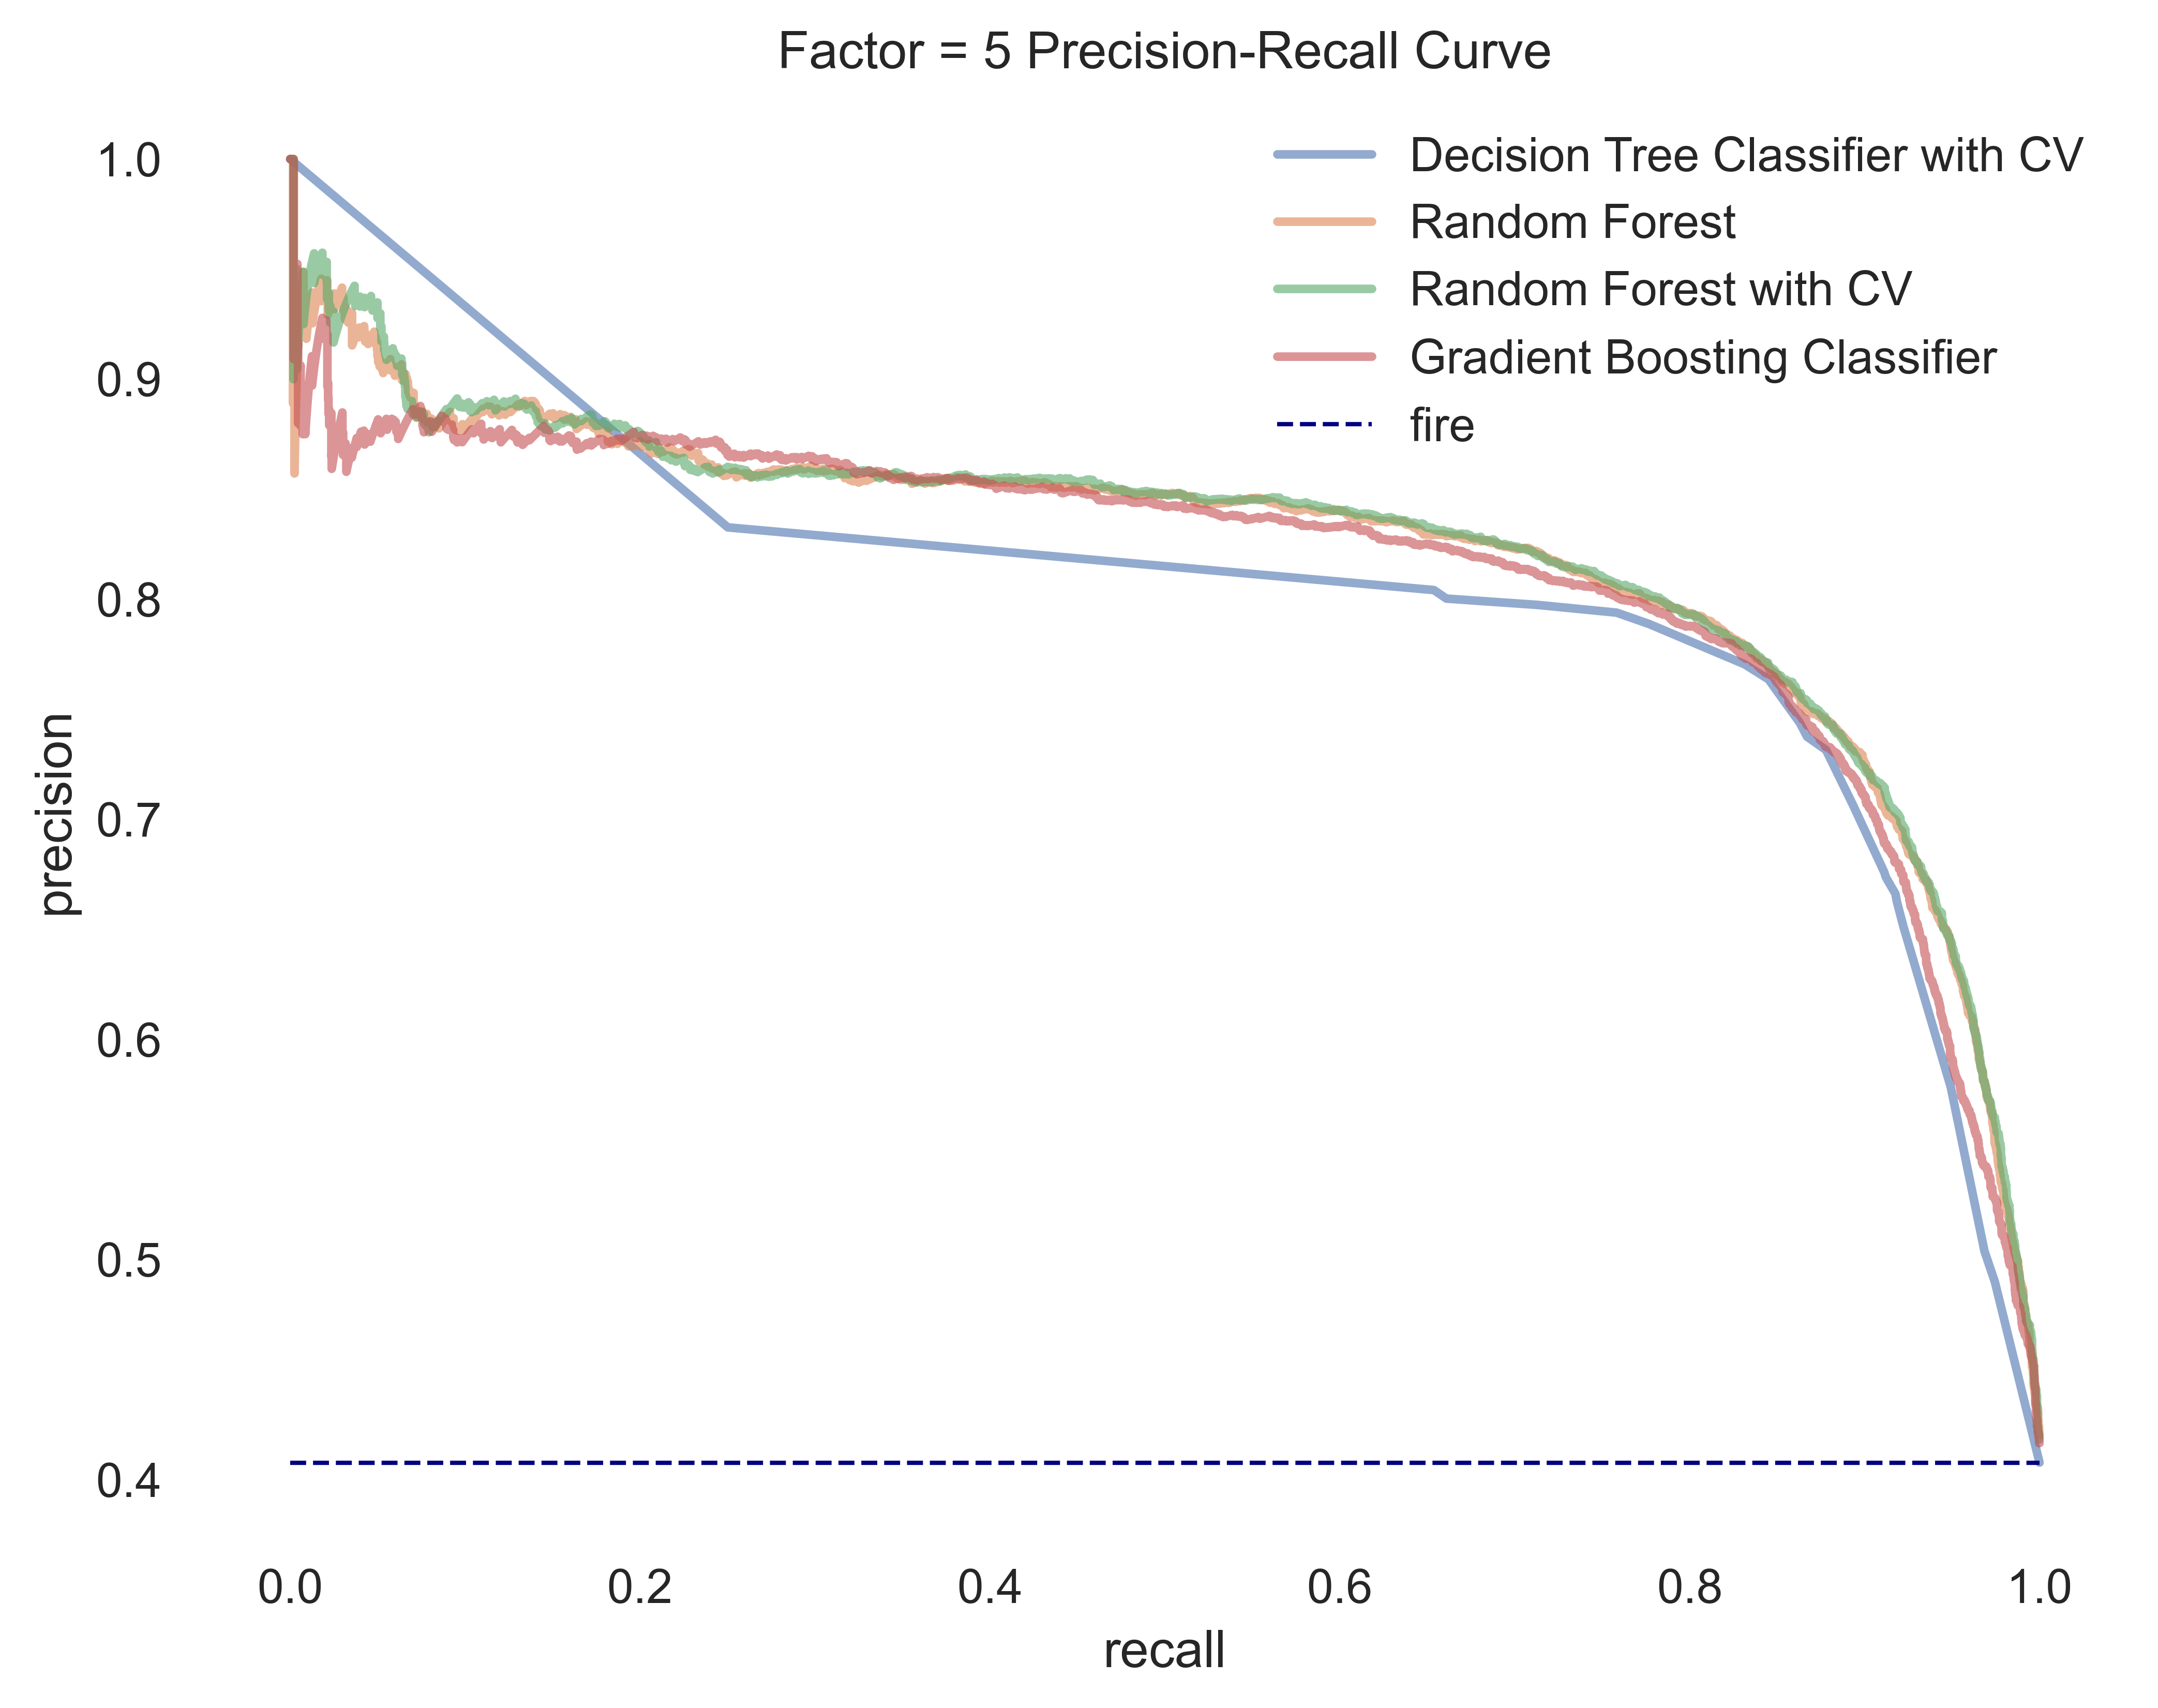

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fire = sum(y_test) / len(y_test)
for m in range(len(models)):
    y_prob = list(models.values())[m].predict_proba(X_test)[:,1]
    y_pred = list(models.values())[m].predict(X_test)
    precision, recall, threshold = precision_recall_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(recall, precision, lw=2, alpha=0.6,
            label=f'{list(models.keys())[m]}')
ax.plot([0, 1], [fire, fire], color='navy', lw=1, 
         linestyle='--', label='fire')
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.title('Factor = 5 Precision-Recall Curve')
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend(loc='upper right')
plt.show()

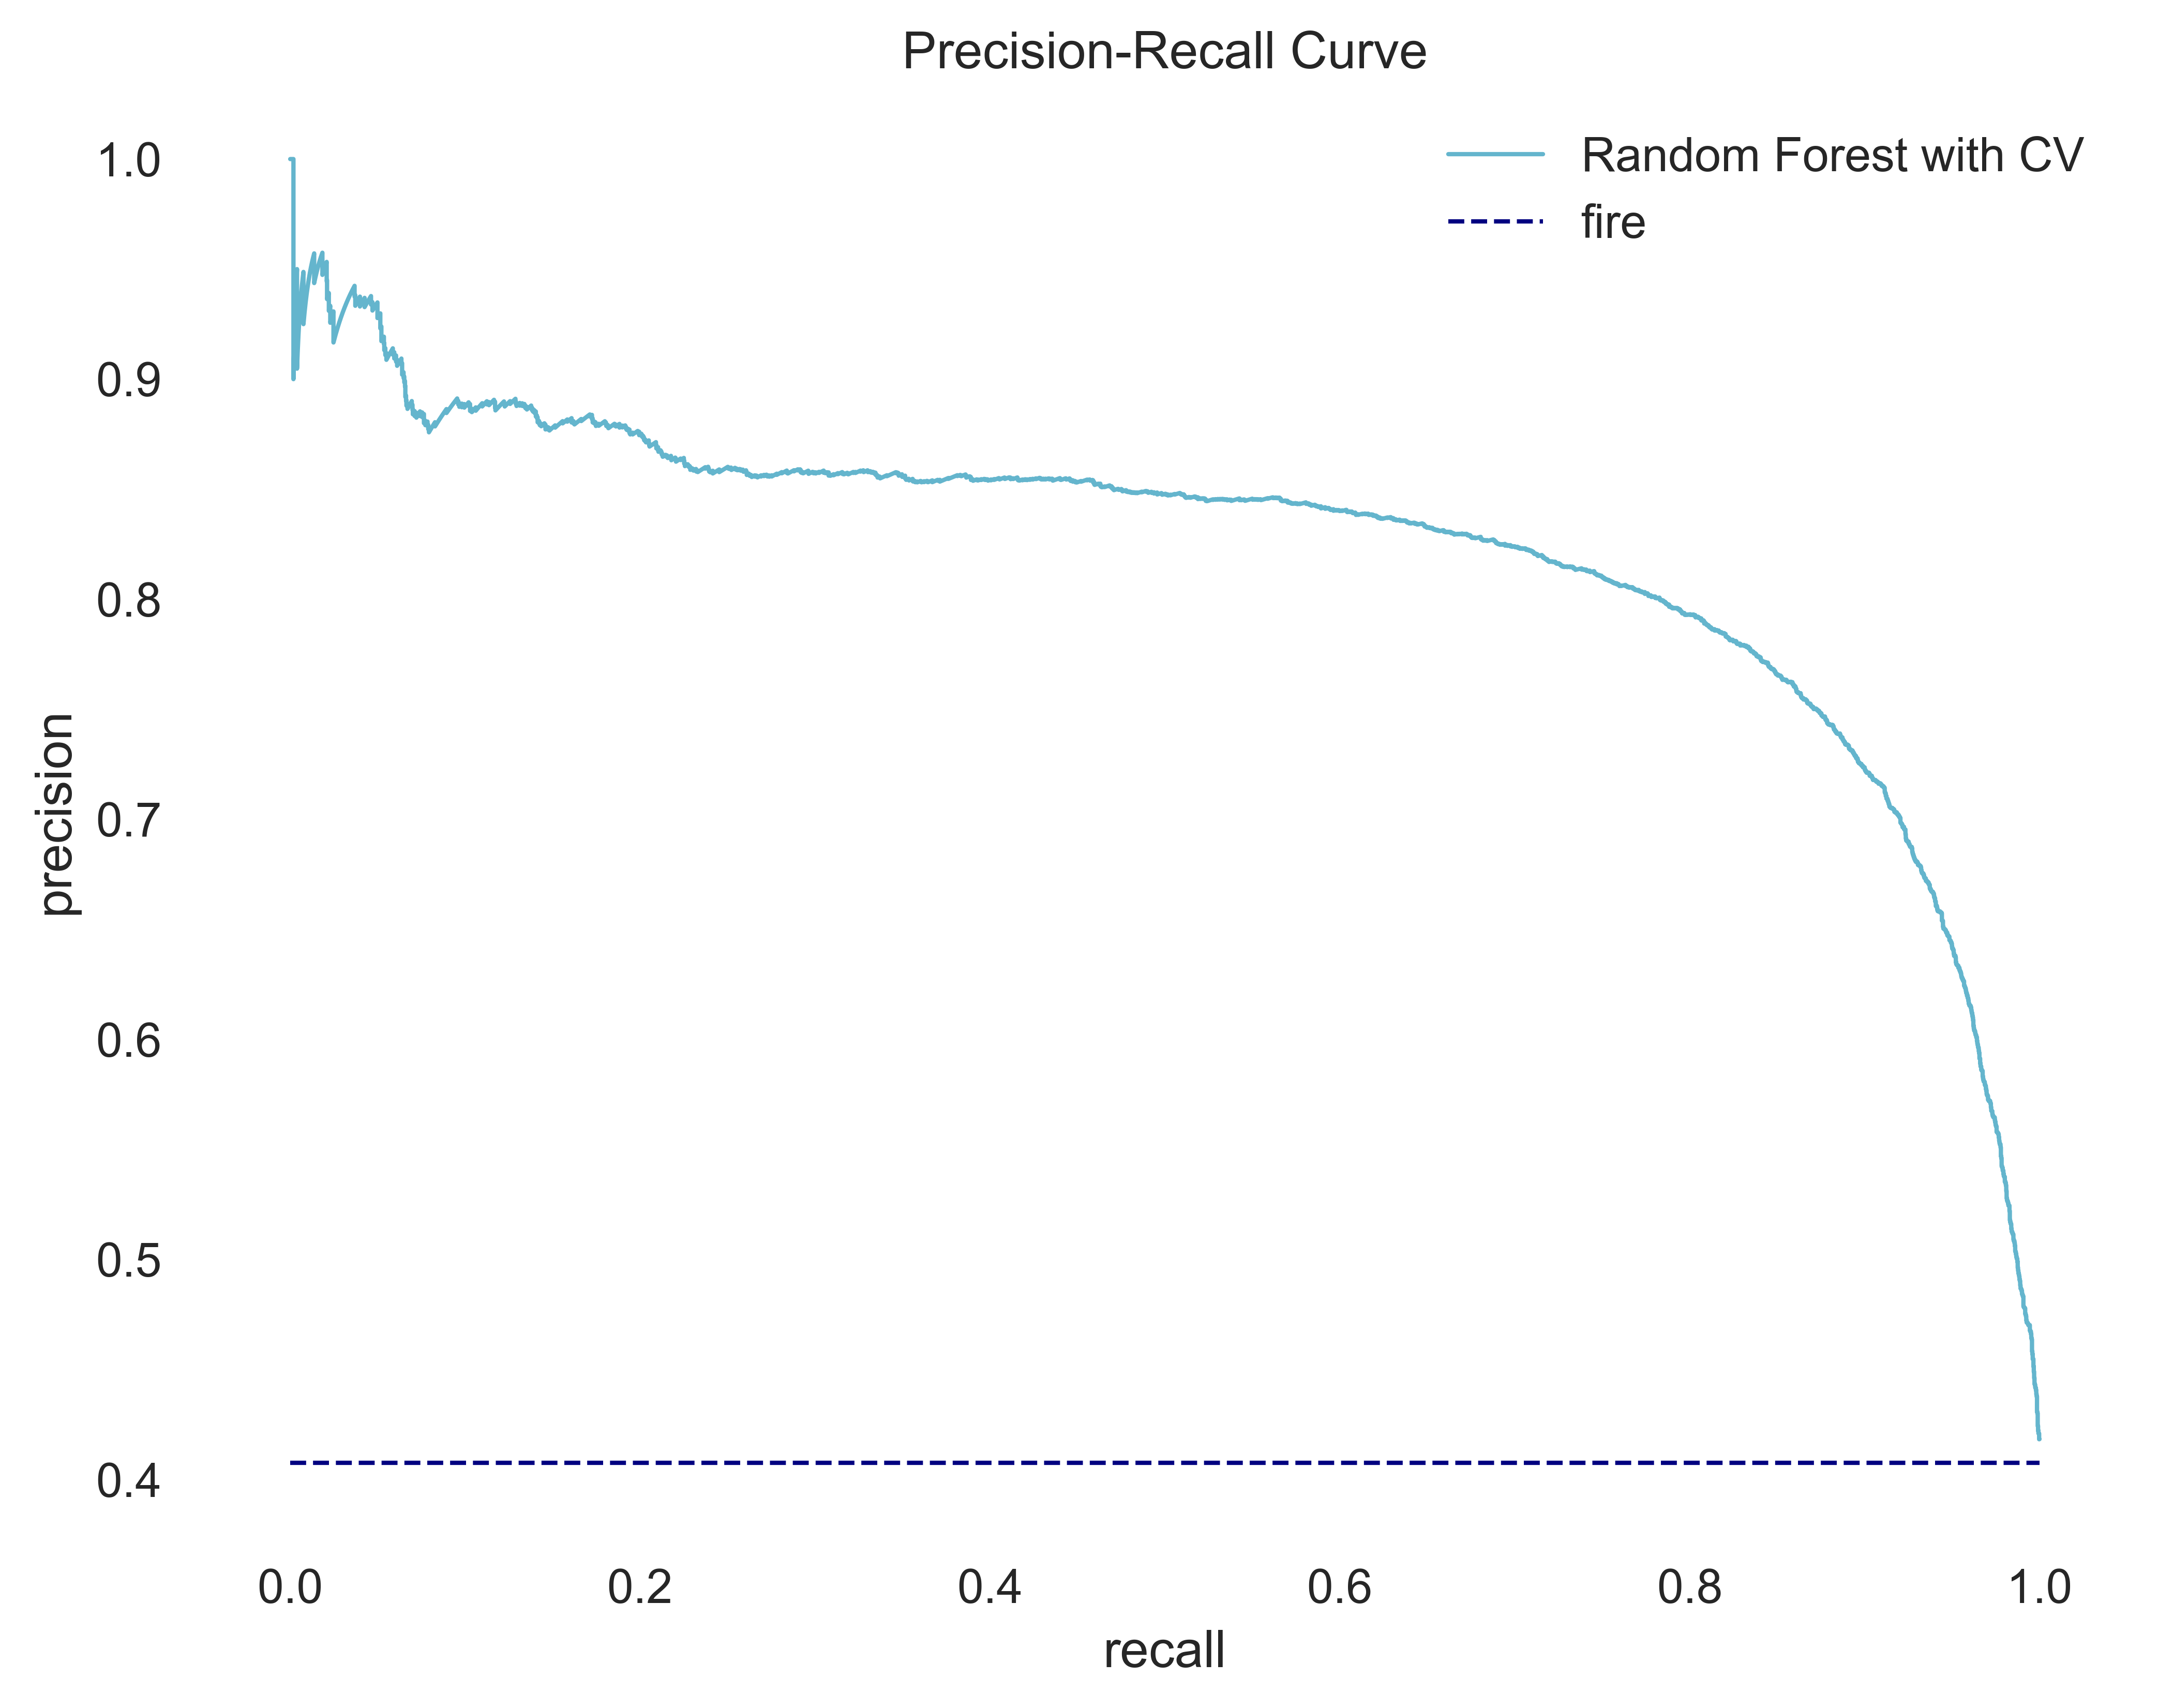

In [37]:
y_prob = rf_cv.predict_proba(X_test)[:,1]
y_pred = rf_cv.predict(X_test)
precision, recall, threshold = precision_recall_curve(y_test, y_prob)
fire = sum(y_test) / len(y_test)
plt.plot(recall, precision, color='c', lw=1, 
         label='Random Forest with CV')
plt.plot([0, 1], [fire, fire], color='navy', lw=1, 
         linestyle='--', label='fire')
plt.title('Precision-Recall Curve')
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend(loc='upper right')
plt.show()